# VGG11B - CIFAR-10

In [1]:
import numpy as np
import cupy as cp
import pathlib
import pickle
import csv
import sys

In [2]:
sys.path.append(str(pathlib.Path('../../').resolve()))

In [3]:
from lib.experiments import train_test_experiment, build_CNN, build_augmentation_pipeline
from lib.utils.enums import NonLinearity, Initialization, Dataset, OptimizerName
from lib.utils.data import load_integer_dataset

## Experiments config

In [4]:
architecture = [
    ('Conv2d', 128, 3, 1, 1),
    ('Conv2d', 128, 3, 1, 1),
    ('Conv2d', 128, 3, 1, 1),
    ('Conv2d', 256, 3, 1, 1),
    ('MaxPool2d', 2, 2),
    ('Conv2d', 256, 3, 1, 1),
    ('Conv2d', 512, 3, 1, 1),
    ('MaxPool2d', 2, 2),
    ('Conv2d', 512, 3, 1, 1),
    ('Conv2d', 512, 3, 1, 1),
    ('MaxPool2d', 2, 2),
    ('Conv2d', 512, 3, 1, 1),
    ('MaxPool2d', 2, 2),
]
num_fc_layers = 2
num_fc_hidden = [1024]

In [5]:
dataset_config = dict(
    dataset=Dataset.CIFAR10.name,
    subsample_ratio=1.0,
    ohe_values=(0, 32),
    data_augmentation=True,
    normalize=True,
)

In [6]:
network_config = dict(
    architecture=architecture,
    num_fc_layers=num_fc_layers,
    num_fc_hidden=num_fc_hidden,
    non_linearity=NonLinearity.NITRO_LEAKY_RELU.name,
    init=Initialization.UNIFORM_KAIMING_LEAKY_RELU.name,
    pred_decoder_dim=4096,
    fc_dropout_rate=0.0,
    fe_dropout_rate=0.0,
    seed=42,
    dtype='int32',
    device='cuda',
    local_loss='pred',
    pooling_type='max',
    bias=False,
    debug=False,
)

In [7]:
training_config = dict(
    batch_size=64,
    num_epochs=150,
    lr_inv=512,
    lr_amp_factor=640,
    fwd_decay_inv=28_000,
    subnet_decay_inv=4500,
    optimizer=OptimizerName.INTEGER_SGD.name,
)

In [8]:
config = dataset_config | network_config | training_config

## Run the configuration

Files already downloaded and verified
Files already downloaded and verified
Training on 50000 samples
Data normalized. New statistics:
-  Min: [-123 -123 -105]
-  Max: [126 127 127]
- Mean: [0 0 0]
-  Std: [61 61 61]

Moved data to device: <CUDA Device 0>
Train set:  (50000, 3, 32, 32), (50000, 10)
Test set:   (10000, 3, 32, 32), (10000, 10)
Data types: (int8, int8)


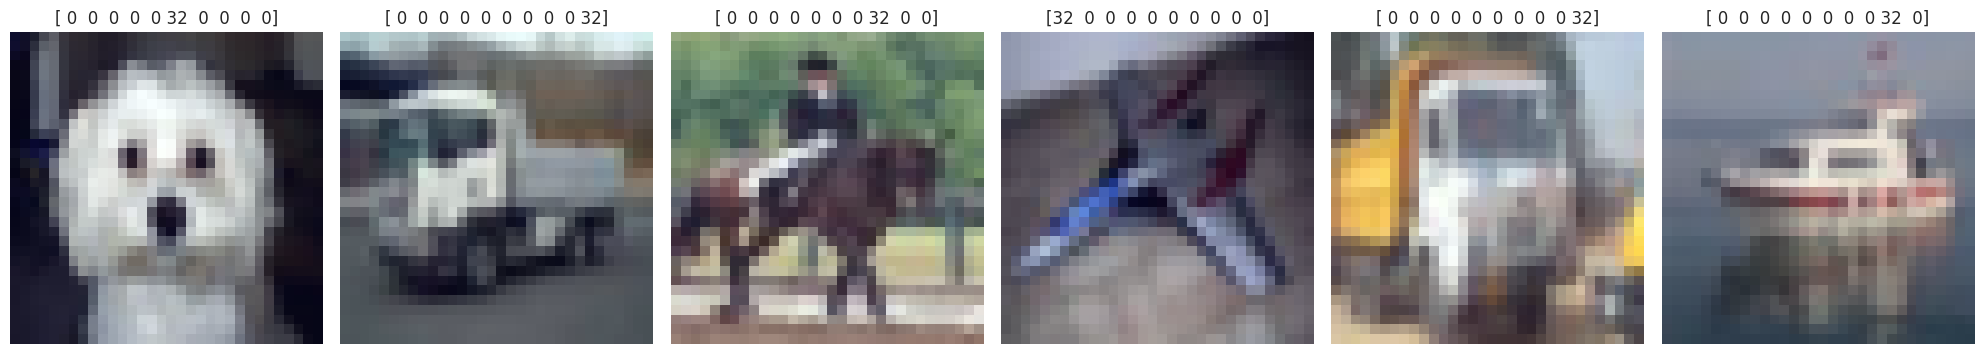

In [9]:
# Show the data and the model
dataset = load_integer_dataset(config, ohe_values=config["ohe_values"], val_dim=0, show_images=True, data_path='../.data')
X_train, _, _, y_train, _, _ = dataset

In [10]:
model = build_CNN(config, X_tr=X_train, y_tr=y_train)
print(model.extra_repr(1))

IntegerLocalLossCNN(
	(0): Sequential(
			(0): LocalConv2dBlock(
			(0): IntegerConv2d(in_channels=3, out_channels=128, bias=False, decay_rate_inv=28000)
			(1): ConstantScaling(fwd_factor=6912, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): MaxPool2d(kernel_size=(8, 4), stride=(8, 4), padding=(0, 0))
			(1): Flatten()
			(2): IntegerLinear(in_features=4096, out_features=10, bias=False, decay_rate_inv=4500)
			(3): ConstantScaling(fwd_factor=1048576, bwd_factor=1)
		)
	)
			(1): LocalConv2dBlock(
			(0): IntegerConv2d(in_channels=128, out_channels=128, bias=False, decay_rate_inv=28000)
			(1): ConstantScaling(fwd_factor=294912, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): MaxPool2d(kernel_size=(8, 4), stride=(8, 4), padding=(0, 0))
			(1): Flatten()
			(2): IntegerLinear(in_features=4096, out_features=10, bias=False, decay_rate_inv=4500)
			(3): ConstantScaling(fwd_factor=10485

In [11]:
def run_experiment(exp_config):
    # Setup reproducibility
    print(f"{'-' * 64}")
    print(f"Running experiment with seed {exp_config['seed']}...")
    np.random.seed(exp_config["seed"])
    cp.random.seed(exp_config["seed"])
    
    # Load the dataset
    data = load_integer_dataset(exp_config, ohe_values=exp_config["ohe_values"], val_dim=0, show_images=False, show_log=False, data_path='../.data')
    X_tr, _, X_test, y_tr, _, y_test = data

    # Setup data augmentation
    augmentation_pipeline = build_augmentation_pipeline(exp_config)

    # Build and train the model
    m = build_CNN(exp_config, X_tr=X_tr, y_tr=y_tr)    
    best_train_acc, best_test_acc = train_test_experiment(
        m, exp_config, X_tr=X_tr, X_te=X_test, y_tr=y_tr, y_te=y_test,
        augmentation_pipeline=augmentation_pipeline,
        show_local_accuracies=False, show_progress_bar=False
    )

    # Append the results to a CSV file
    with open('./results.csv', mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([exp_config["seed"], best_train_acc, best_test_acc])
        
    # Save the first model
    if not pathlib.Path('model.pkl').exists():
        with open('model.pkl', 'wb') as f:
            pickle.dump(m, f)

In [12]:
N_EXPERIMENTS = 10
for i in range(N_EXPERIMENTS):
    run_experiment(config)
    config["seed"] += 1

----------------------------------------------------------------
Running experiment with seed 42...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.055% - Test accuracy: 09.986%


Epoch   2/150 - Train accuracy: 22.217% - Test accuracy: 32.021%


Epoch   3/150 - Train accuracy: 35.389% - Test accuracy: 42.037%


Epoch   4/150 - Train accuracy: 43.514% - Test accuracy: 47.997%


Epoch   5/150 - Train accuracy: 48.409% - Test accuracy: 52.434%


Epoch   6/150 - Train accuracy: 53.319% - Test accuracy: 58.644%


Epoch   7/150 - Train accuracy: 57.404% - Test accuracy: 58.934%


Epoch   8/150 - Train accuracy: 60.175% - Test accuracy: 62.941%


Epoch   9/150 - Train accuracy: 62.024% - Test accuracy: 64.313%


Epoch  10/150 - Train accuracy: 64.317% - Test accuracy: 69.151%


Epoch  11/150 - Train accuracy: 65.325% - Test accuracy: 66.306%


Epoch  12/150 - Train accuracy: 67.131% - Test accuracy: 69.101%


Epoch  13/150 - Train accuracy: 68.086% - Test accuracy: 72.185%


Epoch  14/150 - Train accuracy: 69.298% - Test accuracy: 72.586%


Epoch  15/150 - Train accuracy: 69.872% - Test accuracy: 70.733%


Epoch  16/150 - Train accuracy: 71.001% - Test accuracy: 71.995%


Epoch  17/150 - Train accuracy: 71.711% - Test accuracy: 71.364%


Epoch  18/150 - Train accuracy: 72.351% - Test accuracy: 72.776%


Epoch  19/150 - Train accuracy: 73.035% - Test accuracy: 70.913%


Epoch  20/150 - Train accuracy: 73.886% - Test accuracy: 73.898%


Epoch  21/150 - Train accuracy: 74.252% - Test accuracy: 73.848%


Epoch  22/150 - Train accuracy: 74.676% - Test accuracy: 74.820%


Epoch  23/150 - Train accuracy: 75.386% - Test accuracy: 77.294%


Epoch  24/150 - Train accuracy: 75.554% - Test accuracy: 75.190%


Epoch  25/150 - Train accuracy: 76.168% - Test accuracy: 74.950%


Epoch  26/150 - Train accuracy: 76.502% - Test accuracy: 76.943%


Epoch  27/150 - Train accuracy: 76.699% - Test accuracy: 75.962%


Epoch  28/150 - Train accuracy: 77.487% - Test accuracy: 73.968%


Epoch  29/150 - Train accuracy: 77.677% - Test accuracy: 76.803%


Epoch  30/150 - Train accuracy: 77.865% - Test accuracy: 77.835%


Epoch  31/150 - Train accuracy: 78.739% - Test accuracy: 77.664%


Epoch  32/150 - Train accuracy: 78.659% - Test accuracy: 77.484%


Epoch  33/150 - Train accuracy: 78.909% - Test accuracy: 77.774%


Epoch  34/150 - Train accuracy: 79.255% - Test accuracy: 78.486%


Epoch  35/150 - Train accuracy: 79.541% - Test accuracy: 78.986%


Epoch  36/150 - Train accuracy: 79.507% - Test accuracy: 77.424%


Epoch  37/150 - Train accuracy: 79.671% - Test accuracy: 78.145%


Epoch  38/150 - Train accuracy: 80.192% - Test accuracy: 79.157%


Epoch  39/150 - Train accuracy: 80.688% - Test accuracy: 79.407%


Epoch  40/150 - Train accuracy: 80.528% - Test accuracy: 80.008%


Epoch  41/150 - Train accuracy: 80.770% - Test accuracy: 78.085%


Epoch  42/150 - Train accuracy: 80.880% - Test accuracy: 80.078%


Epoch  43/150 - Train accuracy: 81.128% - Test accuracy: 79.367%


Epoch  44/150 - Train accuracy: 81.288% - Test accuracy: 79.627%


Epoch  45/150 - Train accuracy: 81.464% - Test accuracy: 78.946%


Epoch  46/150 - Train accuracy: 81.336% - Test accuracy: 78.866%


Epoch  47/150 - Train accuracy: 81.656% - Test accuracy: 79.567%


Epoch  48/150 - Train accuracy: 81.624% - Test accuracy: 80.319%


Epoch  49/150 - Train accuracy: 82.068% - Test accuracy: 77.053%


Epoch  50/150 - Train accuracy: 82.140% - Test accuracy: 79.067%


Epoch  51/150 - Train accuracy: 82.162% - Test accuracy: 78.826%


Epoch  52/150 - Train accuracy: 82.288% - Test accuracy: 81.030%


Epoch  53/150 - Train accuracy: 82.292% - Test accuracy: 81.781%


Epoch  54/150 - Train accuracy: 82.778% - Test accuracy: 80.799%


Epoch  55/150 - Train accuracy: 82.604% - Test accuracy: 79.507%


Epoch  56/150 - Train accuracy: 83.341% - Test accuracy: 80.419%


Epoch  57/150 - Train accuracy: 82.949% - Test accuracy: 79.307%


Epoch  58/150 - Train accuracy: 82.889% - Test accuracy: 79.227%


Epoch  59/150 - Train accuracy: 83.505% - Test accuracy: 81.611%


Epoch  60/150 - Train accuracy: 83.201% - Test accuracy: 80.479%


Epoch  61/150 - Train accuracy: 83.125% - Test accuracy: 80.739%


Epoch  62/150 - Train accuracy: 83.511% - Test accuracy: 80.419%


Epoch  63/150 - Train accuracy: 83.229% - Test accuracy: 78.476%


Epoch  64/150 - Train accuracy: 83.321% - Test accuracy: 81.150%


Epoch  65/150 - Train accuracy: 83.551% - Test accuracy: 80.258%


Epoch  66/150 - Train accuracy: 83.405% - Test accuracy: 78.215%


Epoch  67/150 - Train accuracy: 83.575% - Test accuracy: 79.688%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 67
----------------------------------------------------------------


Epoch  68/150 - Train accuracy: 88.430% - Test accuracy: 84.545%


Epoch  69/150 - Train accuracy: 89.083% - Test accuracy: 84.555%


Epoch  70/150 - Train accuracy: 89.375% - Test accuracy: 84.515%


Epoch  71/150 - Train accuracy: 89.739% - Test accuracy: 84.906%


Epoch  72/150 - Train accuracy: 89.621% - Test accuracy: 85.427%


Epoch  73/150 - Train accuracy: 89.873% - Test accuracy: 85.006%


Epoch  74/150 - Train accuracy: 89.913% - Test accuracy: 84.936%


Epoch  75/150 - Train accuracy: 90.309% - Test accuracy: 85.597%


Epoch  76/150 - Train accuracy: 90.113% - Test accuracy: 84.876%


Epoch  77/150 - Train accuracy: 90.365% - Test accuracy: 84.856%


Epoch  78/150 - Train accuracy: 90.161% - Test accuracy: 85.306%


Epoch  79/150 - Train accuracy: 90.787% - Test accuracy: 85.347%


Epoch  80/150 - Train accuracy: 90.531% - Test accuracy: 84.856%


Epoch  81/150 - Train accuracy: 90.577% - Test accuracy: 85.507%


Epoch  82/150 - Train accuracy: 90.771% - Test accuracy: 85.567%


Epoch  83/150 - Train accuracy: 90.729% - Test accuracy: 85.306%


Epoch  84/150 - Train accuracy: 90.789% - Test accuracy: 85.306%


Epoch  85/150 - Train accuracy: 90.875% - Test accuracy: 85.517%


Epoch  86/150 - Train accuracy: 90.995% - Test accuracy: 85.507%


Epoch  87/150 - Train accuracy: 90.917% - Test accuracy: 85.417%


Epoch  88/150 - Train accuracy: 91.013% - Test accuracy: 85.667%


Epoch  89/150 - Train accuracy: 91.195% - Test accuracy: 85.477%


Epoch  90/150 - Train accuracy: 90.803% - Test accuracy: 85.477%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 90
----------------------------------------------------------------


Epoch  91/150 - Train accuracy: 92.466% - Test accuracy: 86.418%


Epoch  92/150 - Train accuracy: 92.702% - Test accuracy: 86.629%


Epoch  93/150 - Train accuracy: 92.790% - Test accuracy: 86.248%


Epoch  94/150 - Train accuracy: 92.764% - Test accuracy: 86.919%


Epoch  95/150 - Train accuracy: 92.874% - Test accuracy: 86.478%


Epoch  96/150 - Train accuracy: 92.826% - Test accuracy: 86.789%


Epoch  97/150 - Train accuracy: 92.932% - Test accuracy: 86.979%


Epoch  98/150 - Train accuracy: 92.816% - Test accuracy: 86.749%


Epoch  99/150 - Train accuracy: 92.946% - Test accuracy: 86.558%


Epoch 100/150 - Train accuracy: 92.922% - Test accuracy: 86.679%


Epoch 101/150 - Train accuracy: 92.928% - Test accuracy: 86.649%


Epoch 102/150 - Train accuracy: 93.288% - Test accuracy: 86.809%


Epoch 103/150 - Train accuracy: 93.276% - Test accuracy: 86.989%


Epoch 104/150 - Train accuracy: 93.096% - Test accuracy: 86.909%


Epoch 105/150 - Train accuracy: 93.030% - Test accuracy: 86.869%


Epoch 106/150 - Train accuracy: 93.196% - Test accuracy: 86.759%


Epoch 107/150 - Train accuracy: 92.926% - Test accuracy: 86.579%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 107
----------------------------------------------------------------


Epoch 108/150 - Train accuracy: 93.634% - Test accuracy: 87.079%


Epoch 109/150 - Train accuracy: 93.618% - Test accuracy: 87.139%


Epoch 110/150 - Train accuracy: 93.536% - Test accuracy: 87.210%


Epoch 111/150 - Train accuracy: 93.510% - Test accuracy: 87.129%


Epoch 112/150 - Train accuracy: 93.628% - Test accuracy: 87.260%


Epoch 113/150 - Train accuracy: 93.552% - Test accuracy: 87.139%


Epoch 114/150 - Train accuracy: 93.542% - Test accuracy: 87.169%


Epoch 115/150 - Train accuracy: 93.556% - Test accuracy: 87.169%


Epoch 116/150 - Train accuracy: 93.506% - Test accuracy: 87.270%


Epoch 117/150 - Train accuracy: 93.756% - Test accuracy: 87.059%


Epoch 118/150 - Train accuracy: 93.658% - Test accuracy: 87.079%


Epoch 119/150 - Train accuracy: 93.828% - Test accuracy: 87.149%


Epoch 120/150 - Train accuracy: 93.618% - Test accuracy: 87.230%


Epoch 121/150 - Train accuracy: 93.796% - Test accuracy: 87.109%


Epoch 122/150 - Train accuracy: 93.678% - Test accuracy: 86.969%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 122
----------------------------------------------------------------


Epoch 123/150 - Train accuracy: 93.626% - Test accuracy: 87.320%


Epoch 124/150 - Train accuracy: 93.736% - Test accuracy: 87.340%


Epoch 125/150 - Train accuracy: 93.724% - Test accuracy: 87.270%


Epoch 126/150 - Train accuracy: 93.766% - Test accuracy: 87.250%


Epoch 127/150 - Train accuracy: 93.682% - Test accuracy: 87.230%
----------------------------------------------------------------
Early stopping at epoch 127
----------------------------------------------------------------


----------------------------------------------------------------
Running experiment with seed 43...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.193% - Test accuracy: 10.016%


Epoch   2/150 - Train accuracy: 21.021% - Test accuracy: 28.736%


Epoch   3/150 - Train accuracy: 34.177% - Test accuracy: 43.249%


Epoch   4/150 - Train accuracy: 42.720% - Test accuracy: 47.286%


Epoch   5/150 - Train accuracy: 47.887% - Test accuracy: 52.324%


Epoch   6/150 - Train accuracy: 53.009% - Test accuracy: 56.200%


Epoch   7/150 - Train accuracy: 56.472% - Test accuracy: 60.557%


Epoch   8/150 - Train accuracy: 59.805% - Test accuracy: 57.392%


Epoch   9/150 - Train accuracy: 61.690% - Test accuracy: 65.004%


Epoch  10/150 - Train accuracy: 63.448% - Test accuracy: 67.478%


Epoch  11/150 - Train accuracy: 64.981% - Test accuracy: 66.687%


Epoch  12/150 - Train accuracy: 66.579% - Test accuracy: 67.768%


Epoch  13/150 - Train accuracy: 67.954% - Test accuracy: 71.765%


Epoch  14/150 - Train accuracy: 69.394% - Test accuracy: 68.550%


Epoch  15/150 - Train accuracy: 70.216% - Test accuracy: 72.746%


Epoch  16/150 - Train accuracy: 70.631% - Test accuracy: 72.366%


Epoch  17/150 - Train accuracy: 71.437% - Test accuracy: 72.546%


Epoch  18/150 - Train accuracy: 72.441% - Test accuracy: 73.948%


Epoch  19/150 - Train accuracy: 72.845% - Test accuracy: 72.456%


Epoch  20/150 - Train accuracy: 73.862% - Test accuracy: 72.927%


Epoch  21/150 - Train accuracy: 74.158% - Test accuracy: 74.309%


Epoch  22/150 - Train accuracy: 74.760% - Test accuracy: 75.751%


Epoch  23/150 - Train accuracy: 75.266% - Test accuracy: 73.067%


Epoch  24/150 - Train accuracy: 75.692% - Test accuracy: 73.798%


Epoch  25/150 - Train accuracy: 75.794% - Test accuracy: 77.364%


Epoch  26/150 - Train accuracy: 76.456% - Test accuracy: 76.472%


Epoch  27/150 - Train accuracy: 76.925% - Test accuracy: 76.032%


Epoch  28/150 - Train accuracy: 77.413% - Test accuracy: 75.891%


Epoch  29/150 - Train accuracy: 77.505% - Test accuracy: 76.022%


Epoch  30/150 - Train accuracy: 78.063% - Test accuracy: 77.314%


Epoch  31/150 - Train accuracy: 78.335% - Test accuracy: 77.955%


Epoch  32/150 - Train accuracy: 78.687% - Test accuracy: 76.382%


Epoch  33/150 - Train accuracy: 78.725% - Test accuracy: 78.606%


Epoch  34/150 - Train accuracy: 78.899% - Test accuracy: 78.345%


Epoch  35/150 - Train accuracy: 79.231% - Test accuracy: 77.825%


Epoch  36/150 - Train accuracy: 79.431% - Test accuracy: 79.357%


Epoch  37/150 - Train accuracy: 79.958% - Test accuracy: 79.197%


Epoch  38/150 - Train accuracy: 79.822% - Test accuracy: 78.866%


Epoch  39/150 - Train accuracy: 80.570% - Test accuracy: 79.247%


Epoch  40/150 - Train accuracy: 80.430% - Test accuracy: 79.708%


Epoch  41/150 - Train accuracy: 80.638% - Test accuracy: 76.833%


Epoch  42/150 - Train accuracy: 80.852% - Test accuracy: 78.796%


Epoch  43/150 - Train accuracy: 81.142% - Test accuracy: 79.477%


Epoch  44/150 - Train accuracy: 81.344% - Test accuracy: 79.287%


Epoch  45/150 - Train accuracy: 81.050% - Test accuracy: 79.758%


Epoch  46/150 - Train accuracy: 81.808% - Test accuracy: 79.367%


Epoch  47/150 - Train accuracy: 81.536% - Test accuracy: 79.778%


Epoch  48/150 - Train accuracy: 81.906% - Test accuracy: 78.846%


Epoch  49/150 - Train accuracy: 81.500% - Test accuracy: 79.958%


Epoch  50/150 - Train accuracy: 81.668% - Test accuracy: 79.738%


Epoch  51/150 - Train accuracy: 82.206% - Test accuracy: 77.274%


Epoch  52/150 - Train accuracy: 82.304% - Test accuracy: 79.277%


Epoch  53/150 - Train accuracy: 82.152% - Test accuracy: 79.988%


Epoch  54/150 - Train accuracy: 82.412% - Test accuracy: 80.258%


Epoch  55/150 - Train accuracy: 82.536% - Test accuracy: 77.244%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 55
----------------------------------------------------------------


Epoch  56/150 - Train accuracy: 87.276% - Test accuracy: 84.125%


Epoch  57/150 - Train accuracy: 87.728% - Test accuracy: 83.924%


Epoch  58/150 - Train accuracy: 88.102% - Test accuracy: 84.595%


Epoch  59/150 - Train accuracy: 87.918% - Test accuracy: 84.205%


Epoch  60/150 - Train accuracy: 88.562% - Test accuracy: 84.545%


Epoch  61/150 - Train accuracy: 88.594% - Test accuracy: 84.685%


Epoch  62/150 - Train accuracy: 88.896% - Test accuracy: 84.675%


Epoch  63/150 - Train accuracy: 88.858% - Test accuracy: 84.435%


Epoch  64/150 - Train accuracy: 89.145% - Test accuracy: 84.565%


Epoch  65/150 - Train accuracy: 89.103% - Test accuracy: 84.575%


Epoch  66/150 - Train accuracy: 89.345% - Test accuracy: 84.655%


Epoch  67/150 - Train accuracy: 89.419% - Test accuracy: 85.387%


Epoch  68/150 - Train accuracy: 89.311% - Test accuracy: 84.826%


Epoch  69/150 - Train accuracy: 89.583% - Test accuracy: 84.826%


Epoch  70/150 - Train accuracy: 89.491% - Test accuracy: 85.086%


Epoch  71/150 - Train accuracy: 89.641% - Test accuracy: 85.196%


Epoch  72/150 - Train accuracy: 89.639% - Test accuracy: 85.106%


Epoch  73/150 - Train accuracy: 89.789% - Test accuracy: 85.216%


Epoch  74/150 - Train accuracy: 89.859% - Test accuracy: 85.036%


Epoch  75/150 - Train accuracy: 90.009% - Test accuracy: 84.265%


Epoch  76/150 - Train accuracy: 89.731% - Test accuracy: 85.477%


Epoch  77/150 - Train accuracy: 90.259% - Test accuracy: 85.337%


Epoch  78/150 - Train accuracy: 90.063% - Test accuracy: 84.395%


Epoch  79/150 - Train accuracy: 90.165% - Test accuracy: 85.417%


Epoch  80/150 - Train accuracy: 90.227% - Test accuracy: 84.736%


Epoch  81/150 - Train accuracy: 90.329% - Test accuracy: 85.727%


Epoch  82/150 - Train accuracy: 90.485% - Test accuracy: 84.696%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 82
----------------------------------------------------------------


Epoch  83/150 - Train accuracy: 91.953% - Test accuracy: 86.689%


Epoch  84/150 - Train accuracy: 92.200% - Test accuracy: 86.699%


Epoch  85/150 - Train accuracy: 92.314% - Test accuracy: 86.669%


Epoch  86/150 - Train accuracy: 92.250% - Test accuracy: 86.398%


Epoch  87/150 - Train accuracy: 92.123% - Test accuracy: 86.719%


Epoch  88/150 - Train accuracy: 92.330% - Test accuracy: 86.438%


Epoch  89/150 - Train accuracy: 92.398% - Test accuracy: 86.428%


Epoch  90/150 - Train accuracy: 92.308% - Test accuracy: 86.839%


Epoch  91/150 - Train accuracy: 91.991% - Test accuracy: 86.458%


Epoch  92/150 - Train accuracy: 92.238% - Test accuracy: 86.899%


Epoch  93/150 - Train accuracy: 92.584% - Test accuracy: 86.348%


Epoch  94/150 - Train accuracy: 92.576% - Test accuracy: 86.849%


Epoch  95/150 - Train accuracy: 92.356% - Test accuracy: 86.639%


Epoch  96/150 - Train accuracy: 92.500% - Test accuracy: 86.639%


Epoch  97/150 - Train accuracy: 92.482% - Test accuracy: 86.799%


Epoch  98/150 - Train accuracy: 92.402% - Test accuracy: 86.749%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 98
----------------------------------------------------------------


Epoch  99/150 - Train accuracy: 92.886% - Test accuracy: 87.029%


Epoch 100/150 - Train accuracy: 93.092% - Test accuracy: 87.079%


Epoch 101/150 - Train accuracy: 92.934% - Test accuracy: 87.139%


Epoch 102/150 - Train accuracy: 93.156% - Test accuracy: 87.159%


Epoch 103/150 - Train accuracy: 93.066% - Test accuracy: 87.019%


Epoch 104/150 - Train accuracy: 93.040% - Test accuracy: 87.079%


Epoch 105/150 - Train accuracy: 93.028% - Test accuracy: 86.899%


Epoch 106/150 - Train accuracy: 92.920% - Test accuracy: 86.899%


Epoch 107/150 - Train accuracy: 93.020% - Test accuracy: 87.079%


Epoch 108/150 - Train accuracy: 93.126% - Test accuracy: 86.949%


Epoch 109/150 - Train accuracy: 92.958% - Test accuracy: 87.019%


Epoch 110/150 - Train accuracy: 93.044% - Test accuracy: 86.799%


Epoch 111/150 - Train accuracy: 93.056% - Test accuracy: 87.019%


Epoch 112/150 - Train accuracy: 93.126% - Test accuracy: 86.949%


Epoch 113/150 - Train accuracy: 93.158% - Test accuracy: 86.899%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 113
----------------------------------------------------------------


Epoch 114/150 - Train accuracy: 93.110% - Test accuracy: 87.069%


Epoch 115/150 - Train accuracy: 93.362% - Test accuracy: 87.019%


Epoch 116/150 - Train accuracy: 93.194% - Test accuracy: 86.959%


Epoch 117/150 - Train accuracy: 93.142% - Test accuracy: 86.959%


Epoch 118/150 - Train accuracy: 93.058% - Test accuracy: 87.059%
----------------------------------------------------------------
Early stopping at epoch 118
----------------------------------------------------------------


----------------------------------------------------------------
Running experiment with seed 44...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.155% - Test accuracy: 09.996%


Epoch   2/150 - Train accuracy: 21.599% - Test accuracy: 31.931%


Epoch   3/150 - Train accuracy: 34.763% - Test accuracy: 37.750%


Epoch   4/150 - Train accuracy: 42.214% - Test accuracy: 45.813%


Epoch   5/150 - Train accuracy: 48.165% - Test accuracy: 51.072%


Epoch   6/150 - Train accuracy: 53.035% - Test accuracy: 54.237%


Epoch   7/150 - Train accuracy: 57.258% - Test accuracy: 56.951%


Epoch   8/150 - Train accuracy: 59.967% - Test accuracy: 64.403%


Epoch   9/150 - Train accuracy: 62.360% - Test accuracy: 65.635%


Epoch  10/150 - Train accuracy: 64.257% - Test accuracy: 68.860%


Epoch  11/150 - Train accuracy: 65.791% - Test accuracy: 69.802%


Epoch  12/150 - Train accuracy: 66.781% - Test accuracy: 68.319%


Epoch  13/150 - Train accuracy: 68.178% - Test accuracy: 71.865%


Epoch  14/150 - Train accuracy: 69.872% - Test accuracy: 71.274%


Epoch  15/150 - Train accuracy: 70.222% - Test accuracy: 68.620%


Epoch  16/150 - Train accuracy: 70.987% - Test accuracy: 73.057%


Epoch  17/150 - Train accuracy: 71.973% - Test accuracy: 73.227%


Epoch  18/150 - Train accuracy: 72.891% - Test accuracy: 71.514%


Epoch  19/150 - Train accuracy: 73.349% - Test accuracy: 73.297%


Epoch  20/150 - Train accuracy: 73.866% - Test accuracy: 73.027%


Epoch  21/150 - Train accuracy: 74.262% - Test accuracy: 72.776%


Epoch  22/150 - Train accuracy: 74.658% - Test accuracy: 73.798%


Epoch  23/150 - Train accuracy: 75.618% - Test accuracy: 75.020%


Epoch  24/150 - Train accuracy: 76.008% - Test accuracy: 74.690%


Epoch  25/150 - Train accuracy: 76.486% - Test accuracy: 74.289%


Epoch  26/150 - Train accuracy: 76.482% - Test accuracy: 76.963%


Epoch  27/150 - Train accuracy: 77.153% - Test accuracy: 77.284%


Epoch  28/150 - Train accuracy: 77.283% - Test accuracy: 77.624%


Epoch  29/150 - Train accuracy: 77.889% - Test accuracy: 74.589%


Epoch  30/150 - Train accuracy: 78.029% - Test accuracy: 76.753%


Epoch  31/150 - Train accuracy: 78.463% - Test accuracy: 76.883%


Epoch  32/150 - Train accuracy: 78.689% - Test accuracy: 77.654%


Epoch  33/150 - Train accuracy: 78.759% - Test accuracy: 76.993%


Epoch  34/150 - Train accuracy: 79.155% - Test accuracy: 77.965%


Epoch  35/150 - Train accuracy: 79.746% - Test accuracy: 77.804%


Epoch  36/150 - Train accuracy: 79.553% - Test accuracy: 79.337%


Epoch  37/150 - Train accuracy: 79.876% - Test accuracy: 78.736%


Epoch  38/150 - Train accuracy: 80.264% - Test accuracy: 78.716%


Epoch  39/150 - Train accuracy: 80.306% - Test accuracy: 80.078%


Epoch  40/150 - Train accuracy: 80.452% - Test accuracy: 79.117%


Epoch  41/150 - Train accuracy: 80.550% - Test accuracy: 78.536%


Epoch  42/150 - Train accuracy: 81.114% - Test accuracy: 79.587%


Epoch  43/150 - Train accuracy: 81.040% - Test accuracy: 78.496%


Epoch  44/150 - Train accuracy: 81.502% - Test accuracy: 80.178%


Epoch  45/150 - Train accuracy: 81.472% - Test accuracy: 79.317%


Epoch  46/150 - Train accuracy: 81.708% - Test accuracy: 80.549%


Epoch  47/150 - Train accuracy: 81.920% - Test accuracy: 80.058%


Epoch  48/150 - Train accuracy: 82.004% - Test accuracy: 78.506%


Epoch  49/150 - Train accuracy: 82.144% - Test accuracy: 78.786%


Epoch  50/150 - Train accuracy: 81.830% - Test accuracy: 77.404%


Epoch  51/150 - Train accuracy: 82.272% - Test accuracy: 80.439%


Epoch  52/150 - Train accuracy: 82.280% - Test accuracy: 77.494%


Epoch  53/150 - Train accuracy: 82.526% - Test accuracy: 78.856%


Epoch  54/150 - Train accuracy: 82.498% - Test accuracy: 80.909%


Epoch  55/150 - Train accuracy: 82.837% - Test accuracy: 81.010%


Epoch  56/150 - Train accuracy: 83.047% - Test accuracy: 80.859%


Epoch  57/150 - Train accuracy: 82.837% - Test accuracy: 80.950%


Epoch  58/150 - Train accuracy: 83.295% - Test accuracy: 80.419%


Epoch  59/150 - Train accuracy: 82.688% - Test accuracy: 81.150%


Epoch  60/150 - Train accuracy: 83.205% - Test accuracy: 79.768%


Epoch  61/150 - Train accuracy: 83.349% - Test accuracy: 79.427%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 61
----------------------------------------------------------------


Epoch  62/150 - Train accuracy: 87.706% - Test accuracy: 84.355%


Epoch  63/150 - Train accuracy: 88.730% - Test accuracy: 84.455%


Epoch  64/150 - Train accuracy: 88.788% - Test accuracy: 84.806%


Epoch  65/150 - Train accuracy: 89.159% - Test accuracy: 84.936%


Epoch  66/150 - Train accuracy: 89.253% - Test accuracy: 84.355%


Epoch  67/150 - Train accuracy: 89.369% - Test accuracy: 85.046%


Epoch  68/150 - Train accuracy: 89.605% - Test accuracy: 84.996%


Epoch  69/150 - Train accuracy: 89.677% - Test accuracy: 85.226%


Epoch  70/150 - Train accuracy: 89.789% - Test accuracy: 85.106%


Epoch  71/150 - Train accuracy: 89.739% - Test accuracy: 84.685%


Epoch  72/150 - Train accuracy: 89.855% - Test accuracy: 84.846%


Epoch  73/150 - Train accuracy: 90.103% - Test accuracy: 85.667%


Epoch  74/150 - Train accuracy: 90.077% - Test accuracy: 84.916%


Epoch  75/150 - Train accuracy: 89.927% - Test accuracy: 85.767%


Epoch  76/150 - Train accuracy: 90.109% - Test accuracy: 84.896%


Epoch  77/150 - Train accuracy: 90.247% - Test accuracy: 85.767%


Epoch  78/150 - Train accuracy: 90.209% - Test accuracy: 84.245%


Epoch  79/150 - Train accuracy: 90.533% - Test accuracy: 85.306%


Epoch  80/150 - Train accuracy: 90.321% - Test accuracy: 85.146%


Epoch  81/150 - Train accuracy: 90.329% - Test accuracy: 85.266%


Epoch  82/150 - Train accuracy: 90.597% - Test accuracy: 85.587%


Epoch  83/150 - Train accuracy: 90.527% - Test accuracy: 85.006%


Epoch  84/150 - Train accuracy: 90.765% - Test accuracy: 84.746%


Epoch  85/150 - Train accuracy: 90.681% - Test accuracy: 84.926%


Epoch  86/150 - Train accuracy: 90.713% - Test accuracy: 85.427%


Epoch  87/150 - Train accuracy: 91.025% - Test accuracy: 84.886%


Epoch  88/150 - Train accuracy: 90.929% - Test accuracy: 84.555%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 88
----------------------------------------------------------------


Epoch  89/150 - Train accuracy: 92.392% - Test accuracy: 86.328%


Epoch  90/150 - Train accuracy: 92.386% - Test accuracy: 86.619%


Epoch  91/150 - Train accuracy: 92.654% - Test accuracy: 86.428%


Epoch  92/150 - Train accuracy: 92.486% - Test accuracy: 86.368%


Epoch  93/150 - Train accuracy: 92.550% - Test accuracy: 86.769%


Epoch  94/150 - Train accuracy: 92.670% - Test accuracy: 86.689%


Epoch  95/150 - Train accuracy: 92.638% - Test accuracy: 86.699%


Epoch  96/150 - Train accuracy: 92.730% - Test accuracy: 86.589%


Epoch  97/150 - Train accuracy: 92.822% - Test accuracy: 86.999%


Epoch  98/150 - Train accuracy: 92.786% - Test accuracy: 86.929%


Epoch  99/150 - Train accuracy: 92.936% - Test accuracy: 86.408%


Epoch 100/150 - Train accuracy: 92.838% - Test accuracy: 86.999%


Epoch 101/150 - Train accuracy: 92.838% - Test accuracy: 87.059%


Epoch 102/150 - Train accuracy: 92.818% - Test accuracy: 86.779%


Epoch 103/150 - Train accuracy: 92.728% - Test accuracy: 87.029%


Epoch 104/150 - Train accuracy: 92.864% - Test accuracy: 86.719%


Epoch 105/150 - Train accuracy: 92.836% - Test accuracy: 87.069%


Epoch 106/150 - Train accuracy: 92.954% - Test accuracy: 86.759%


Epoch 107/150 - Train accuracy: 92.948% - Test accuracy: 87.210%


Epoch 108/150 - Train accuracy: 92.758% - Test accuracy: 86.969%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 108
----------------------------------------------------------------


Epoch 109/150 - Train accuracy: 93.200% - Test accuracy: 87.460%


Epoch 110/150 - Train accuracy: 93.406% - Test accuracy: 87.290%


Epoch 111/150 - Train accuracy: 93.306% - Test accuracy: 87.630%


Epoch 112/150 - Train accuracy: 93.620% - Test accuracy: 87.370%


Epoch 113/150 - Train accuracy: 93.520% - Test accuracy: 87.290%


Epoch 114/150 - Train accuracy: 93.650% - Test accuracy: 87.270%


Epoch 115/150 - Train accuracy: 93.522% - Test accuracy: 87.470%


Epoch 116/150 - Train accuracy: 93.470% - Test accuracy: 87.400%


Epoch 117/150 - Train accuracy: 93.494% - Test accuracy: 87.310%


Epoch 118/150 - Train accuracy: 93.482% - Test accuracy: 87.360%


Epoch 119/150 - Train accuracy: 93.414% - Test accuracy: 87.450%


Epoch 120/150 - Train accuracy: 93.624% - Test accuracy: 87.390%


Epoch 121/150 - Train accuracy: 93.520% - Test accuracy: 87.430%


Epoch 122/150 - Train accuracy: 93.562% - Test accuracy: 87.550%


Epoch 123/150 - Train accuracy: 93.454% - Test accuracy: 87.330%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 123
----------------------------------------------------------------


Epoch 124/150 - Train accuracy: 93.816% - Test accuracy: 87.500%


Epoch 125/150 - Train accuracy: 93.480% - Test accuracy: 87.580%


Epoch 126/150 - Train accuracy: 93.682% - Test accuracy: 87.610%


Epoch 127/150 - Train accuracy: 93.626% - Test accuracy: 87.490%


Epoch 128/150 - Train accuracy: 93.834% - Test accuracy: 87.510%
----------------------------------------------------------------
Early stopping at epoch 128
----------------------------------------------------------------


----------------------------------------------------------------
Running experiment with seed 45...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 09.925% - Test accuracy: 09.986%


Epoch   2/150 - Train accuracy: 22.113% - Test accuracy: 28.876%


Epoch   3/150 - Train accuracy: 34.505% - Test accuracy: 39.613%


Epoch   4/150 - Train accuracy: 43.022% - Test accuracy: 46.054%


Epoch   5/150 - Train accuracy: 48.207% - Test accuracy: 49.860%


Epoch   6/150 - Train accuracy: 52.619% - Test accuracy: 54.878%


Epoch   7/150 - Train accuracy: 56.740% - Test accuracy: 60.036%


Epoch   8/150 - Train accuracy: 59.643% - Test accuracy: 62.099%


Epoch   9/150 - Train accuracy: 61.686% - Test accuracy: 62.570%


Epoch  10/150 - Train accuracy: 63.748% - Test accuracy: 69.651%


Epoch  11/150 - Train accuracy: 65.483% - Test accuracy: 67.588%


Epoch  12/150 - Train accuracy: 66.677% - Test accuracy: 67.258%


Epoch  13/150 - Train accuracy: 68.072% - Test accuracy: 67.869%


Epoch  14/150 - Train accuracy: 68.856% - Test accuracy: 68.700%


Epoch  15/150 - Train accuracy: 69.934% - Test accuracy: 68.850%


Epoch  16/150 - Train accuracy: 71.231% - Test accuracy: 69.251%


Epoch  17/150 - Train accuracy: 72.065% - Test accuracy: 73.628%


Epoch  18/150 - Train accuracy: 72.457% - Test accuracy: 72.817%


Epoch  19/150 - Train accuracy: 72.903% - Test accuracy: 73.438%


Epoch  20/150 - Train accuracy: 73.982% - Test accuracy: 74.529%


Epoch  21/150 - Train accuracy: 74.038% - Test accuracy: 76.843%


Epoch  22/150 - Train accuracy: 74.936% - Test accuracy: 75.230%


Epoch  23/150 - Train accuracy: 75.600% - Test accuracy: 73.217%


Epoch  24/150 - Train accuracy: 75.994% - Test accuracy: 77.214%


Epoch  25/150 - Train accuracy: 76.414% - Test accuracy: 76.763%


Epoch  26/150 - Train accuracy: 77.065% - Test accuracy: 77.163%


Epoch  27/150 - Train accuracy: 76.975% - Test accuracy: 74.139%


Epoch  28/150 - Train accuracy: 77.447% - Test accuracy: 76.663%


Epoch  29/150 - Train accuracy: 78.041% - Test accuracy: 77.965%


Epoch  30/150 - Train accuracy: 78.311% - Test accuracy: 76.713%


Epoch  31/150 - Train accuracy: 78.517% - Test accuracy: 77.614%


Epoch  32/150 - Train accuracy: 78.759% - Test accuracy: 78.686%


Epoch  33/150 - Train accuracy: 79.069% - Test accuracy: 77.454%


Epoch  34/150 - Train accuracy: 79.243% - Test accuracy: 77.905%


Epoch  35/150 - Train accuracy: 79.551% - Test accuracy: 79.257%


Epoch  36/150 - Train accuracy: 79.605% - Test accuracy: 78.175%


Epoch  37/150 - Train accuracy: 79.782% - Test accuracy: 78.435%


Epoch  38/150 - Train accuracy: 80.134% - Test accuracy: 79.968%


Epoch  39/150 - Train accuracy: 80.692% - Test accuracy: 79.137%


Epoch  40/150 - Train accuracy: 80.508% - Test accuracy: 77.794%


Epoch  41/150 - Train accuracy: 80.738% - Test accuracy: 79.267%


Epoch  42/150 - Train accuracy: 80.802% - Test accuracy: 79.307%


Epoch  43/150 - Train accuracy: 80.718% - Test accuracy: 78.275%


Epoch  44/150 - Train accuracy: 81.144% - Test accuracy: 79.788%


Epoch  45/150 - Train accuracy: 81.578% - Test accuracy: 79.367%


Epoch  46/150 - Train accuracy: 81.440% - Test accuracy: 78.405%


Epoch  47/150 - Train accuracy: 81.604% - Test accuracy: 77.264%


Epoch  48/150 - Train accuracy: 81.802% - Test accuracy: 79.778%


Epoch  49/150 - Train accuracy: 81.780% - Test accuracy: 78.486%


Epoch  50/150 - Train accuracy: 82.024% - Test accuracy: 80.399%


Epoch  51/150 - Train accuracy: 81.994% - Test accuracy: 79.968%


Epoch  52/150 - Train accuracy: 82.092% - Test accuracy: 80.208%


Epoch  53/150 - Train accuracy: 82.058% - Test accuracy: 79.557%


Epoch  54/150 - Train accuracy: 82.624% - Test accuracy: 80.729%


Epoch  55/150 - Train accuracy: 82.736% - Test accuracy: 80.829%


Epoch  56/150 - Train accuracy: 82.877% - Test accuracy: 79.708%


Epoch  57/150 - Train accuracy: 82.590% - Test accuracy: 79.828%


Epoch  58/150 - Train accuracy: 83.059% - Test accuracy: 77.865%


Epoch  59/150 - Train accuracy: 83.329% - Test accuracy: 78.846%


Epoch  60/150 - Train accuracy: 82.476% - Test accuracy: 80.749%


Epoch  61/150 - Train accuracy: 83.453% - Test accuracy: 80.739%


Epoch  62/150 - Train accuracy: 83.269% - Test accuracy: 81.280%


Epoch  63/150 - Train accuracy: 83.633% - Test accuracy: 81.010%


Epoch  64/150 - Train accuracy: 83.787% - Test accuracy: 80.238%


Epoch  65/150 - Train accuracy: 83.379% - Test accuracy: 79.257%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 65
----------------------------------------------------------------


Epoch  66/150 - Train accuracy: 87.886% - Test accuracy: 83.684%


Epoch  67/150 - Train accuracy: 88.814% - Test accuracy: 84.185%


Epoch  68/150 - Train accuracy: 89.030% - Test accuracy: 84.685%


Epoch  69/150 - Train accuracy: 89.215% - Test accuracy: 84.766%


Epoch  70/150 - Train accuracy: 89.537% - Test accuracy: 84.796%


Epoch  71/150 - Train accuracy: 89.555% - Test accuracy: 85.026%


Epoch  72/150 - Train accuracy: 89.649% - Test accuracy: 84.665%


Epoch  73/150 - Train accuracy: 89.675% - Test accuracy: 84.726%


Epoch  74/150 - Train accuracy: 89.895% - Test accuracy: 84.956%


Epoch  75/150 - Train accuracy: 89.907% - Test accuracy: 84.395%


Epoch  76/150 - Train accuracy: 90.045% - Test accuracy: 85.206%


Epoch  77/150 - Train accuracy: 90.265% - Test accuracy: 84.836%


Epoch  78/150 - Train accuracy: 90.387% - Test accuracy: 83.664%


Epoch  79/150 - Train accuracy: 90.247% - Test accuracy: 84.786%


Epoch  80/150 - Train accuracy: 90.535% - Test accuracy: 85.076%


Epoch  81/150 - Train accuracy: 90.435% - Test accuracy: 85.086%


Epoch  82/150 - Train accuracy: 90.595% - Test accuracy: 85.086%


Epoch  83/150 - Train accuracy: 90.637% - Test accuracy: 85.216%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 83
----------------------------------------------------------------


Epoch  84/150 - Train accuracy: 91.915% - Test accuracy: 86.308%


Epoch  85/150 - Train accuracy: 91.955% - Test accuracy: 86.468%


Epoch  86/150 - Train accuracy: 92.139% - Test accuracy: 86.378%


Epoch  87/150 - Train accuracy: 92.208% - Test accuracy: 86.228%


Epoch  88/150 - Train accuracy: 92.302% - Test accuracy: 86.428%


Epoch  89/150 - Train accuracy: 92.059% - Test accuracy: 86.278%


Epoch  90/150 - Train accuracy: 92.224% - Test accuracy: 86.268%


Epoch  91/150 - Train accuracy: 92.254% - Test accuracy: 86.178%


Epoch  92/150 - Train accuracy: 92.442% - Test accuracy: 86.308%


Epoch  93/150 - Train accuracy: 92.286% - Test accuracy: 86.278%


Epoch  94/150 - Train accuracy: 92.234% - Test accuracy: 85.948%


Epoch  95/150 - Train accuracy: 92.430% - Test accuracy: 86.048%


Epoch  96/150 - Train accuracy: 92.262% - Test accuracy: 86.268%


Epoch  97/150 - Train accuracy: 92.628% - Test accuracy: 86.589%


Epoch  98/150 - Train accuracy: 92.652% - Test accuracy: 86.278%


Epoch  99/150 - Train accuracy: 92.572% - Test accuracy: 86.418%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 99
----------------------------------------------------------------


Epoch 100/150 - Train accuracy: 93.114% - Test accuracy: 86.659%


Epoch 101/150 - Train accuracy: 92.944% - Test accuracy: 86.989%


Epoch 102/150 - Train accuracy: 93.048% - Test accuracy: 86.789%


Epoch 103/150 - Train accuracy: 92.936% - Test accuracy: 86.889%


Epoch 104/150 - Train accuracy: 92.796% - Test accuracy: 86.899%


Epoch 105/150 - Train accuracy: 92.910% - Test accuracy: 86.659%


Epoch 106/150 - Train accuracy: 93.010% - Test accuracy: 86.799%


Epoch 107/150 - Train accuracy: 92.886% - Test accuracy: 86.859%


Epoch 108/150 - Train accuracy: 93.020% - Test accuracy: 86.969%


Epoch 109/150 - Train accuracy: 93.274% - Test accuracy: 86.909%


Epoch 110/150 - Train accuracy: 92.982% - Test accuracy: 86.769%


Epoch 111/150 - Train accuracy: 93.178% - Test accuracy: 86.839%


Epoch 112/150 - Train accuracy: 92.856% - Test accuracy: 86.739%


Epoch 113/150 - Train accuracy: 93.066% - Test accuracy: 86.879%


Epoch 114/150 - Train accuracy: 93.096% - Test accuracy: 86.889%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 114
----------------------------------------------------------------


Epoch 115/150 - Train accuracy: 93.200% - Test accuracy: 86.919%


Epoch 116/150 - Train accuracy: 93.308% - Test accuracy: 86.919%


Epoch 117/150 - Train accuracy: 93.166% - Test accuracy: 86.889%


Epoch 118/150 - Train accuracy: 93.252% - Test accuracy: 86.789%


Epoch 119/150 - Train accuracy: 93.236% - Test accuracy: 86.899%
----------------------------------------------------------------
Early stopping at epoch 119
----------------------------------------------------------------


----------------------------------------------------------------
Running experiment with seed 46...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.179% - Test accuracy: 10.016%


Epoch   2/150 - Train accuracy: 21.769% - Test accuracy: 27.965%


Epoch   3/150 - Train accuracy: 35.537% - Test accuracy: 39.523%


Epoch   4/150 - Train accuracy: 43.522% - Test accuracy: 48.868%


Epoch   5/150 - Train accuracy: 48.566% - Test accuracy: 52.905%


Epoch   6/150 - Train accuracy: 53.429% - Test accuracy: 57.402%


Epoch   7/150 - Train accuracy: 57.348% - Test accuracy: 61.569%


Epoch   8/150 - Train accuracy: 60.097% - Test accuracy: 63.311%


Epoch   9/150 - Train accuracy: 62.240% - Test accuracy: 60.076%


Epoch  10/150 - Train accuracy: 64.177% - Test accuracy: 66.977%


Epoch  11/150 - Train accuracy: 65.421% - Test accuracy: 68.470%


Epoch  12/150 - Train accuracy: 66.985% - Test accuracy: 71.745%


Epoch  13/150 - Train accuracy: 68.402% - Test accuracy: 70.272%


Epoch  14/150 - Train accuracy: 69.372% - Test accuracy: 71.765%


Epoch  15/150 - Train accuracy: 70.507% - Test accuracy: 71.605%


Epoch  16/150 - Train accuracy: 71.251% - Test accuracy: 72.095%


Epoch  17/150 - Train accuracy: 72.035% - Test accuracy: 74.189%


Epoch  18/150 - Train accuracy: 72.719% - Test accuracy: 71.434%


Epoch  19/150 - Train accuracy: 73.209% - Test accuracy: 74.629%


Epoch  20/150 - Train accuracy: 74.038% - Test accuracy: 74.269%


Epoch  21/150 - Train accuracy: 74.566% - Test accuracy: 73.287%


Epoch  22/150 - Train accuracy: 75.262% - Test accuracy: 73.488%


Epoch  23/150 - Train accuracy: 75.278% - Test accuracy: 76.072%


Epoch  24/150 - Train accuracy: 75.864% - Test accuracy: 74.730%


Epoch  25/150 - Train accuracy: 76.506% - Test accuracy: 73.638%


Epoch  26/150 - Train accuracy: 76.913% - Test accuracy: 76.673%


Epoch  27/150 - Train accuracy: 77.341% - Test accuracy: 76.573%


Epoch  28/150 - Train accuracy: 77.433% - Test accuracy: 76.562%


Epoch  29/150 - Train accuracy: 77.785% - Test accuracy: 75.671%


Epoch  30/150 - Train accuracy: 78.275% - Test accuracy: 76.232%


Epoch  31/150 - Train accuracy: 78.517% - Test accuracy: 79.127%


Epoch  32/150 - Train accuracy: 78.797% - Test accuracy: 77.354%


Epoch  33/150 - Train accuracy: 79.485% - Test accuracy: 78.526%


Epoch  34/150 - Train accuracy: 79.477% - Test accuracy: 75.431%


Epoch  35/150 - Train accuracy: 79.702% - Test accuracy: 78.415%


Epoch  36/150 - Train accuracy: 80.058% - Test accuracy: 76.743%


Epoch  37/150 - Train accuracy: 79.806% - Test accuracy: 77.935%


Epoch  38/150 - Train accuracy: 80.190% - Test accuracy: 78.546%


Epoch  39/150 - Train accuracy: 80.552% - Test accuracy: 78.886%


Epoch  40/150 - Train accuracy: 80.986% - Test accuracy: 79.988%


Epoch  41/150 - Train accuracy: 81.002% - Test accuracy: 81.140%


Epoch  42/150 - Train accuracy: 81.092% - Test accuracy: 81.090%


Epoch  43/150 - Train accuracy: 81.650% - Test accuracy: 79.657%


Epoch  44/150 - Train accuracy: 81.764% - Test accuracy: 79.868%


Epoch  45/150 - Train accuracy: 81.912% - Test accuracy: 80.549%


Epoch  46/150 - Train accuracy: 81.564% - Test accuracy: 76.643%


Epoch  47/150 - Train accuracy: 81.680% - Test accuracy: 80.349%


Epoch  48/150 - Train accuracy: 82.204% - Test accuracy: 80.950%


Epoch  49/150 - Train accuracy: 82.198% - Test accuracy: 78.155%


Epoch  50/150 - Train accuracy: 81.830% - Test accuracy: 80.168%


Epoch  51/150 - Train accuracy: 82.328% - Test accuracy: 78.085%


Epoch  52/150 - Train accuracy: 82.336% - Test accuracy: 81.180%


Epoch  53/150 - Train accuracy: 82.688% - Test accuracy: 79.267%


Epoch  54/150 - Train accuracy: 82.558% - Test accuracy: 79.046%


Epoch  55/150 - Train accuracy: 82.995% - Test accuracy: 80.439%


Epoch  56/150 - Train accuracy: 82.810% - Test accuracy: 80.399%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 56
----------------------------------------------------------------


Epoch  57/150 - Train accuracy: 87.402% - Test accuracy: 83.804%


Epoch  58/150 - Train accuracy: 88.198% - Test accuracy: 84.014%


Epoch  59/150 - Train accuracy: 88.492% - Test accuracy: 84.365%


Epoch  60/150 - Train accuracy: 88.606% - Test accuracy: 84.175%


Epoch  61/150 - Train accuracy: 88.886% - Test accuracy: 84.044%


Epoch  62/150 - Train accuracy: 88.770% - Test accuracy: 84.685%


Epoch  63/150 - Train accuracy: 89.187% - Test accuracy: 84.696%


Epoch  64/150 - Train accuracy: 89.127% - Test accuracy: 84.996%


Epoch  65/150 - Train accuracy: 89.375% - Test accuracy: 84.876%


Epoch  66/150 - Train accuracy: 89.209% - Test accuracy: 84.125%


Epoch  67/150 - Train accuracy: 89.371% - Test accuracy: 85.246%


Epoch  68/150 - Train accuracy: 89.583% - Test accuracy: 84.806%


Epoch  69/150 - Train accuracy: 89.687% - Test accuracy: 85.216%


Epoch  70/150 - Train accuracy: 89.637% - Test accuracy: 84.235%


Epoch  71/150 - Train accuracy: 89.883% - Test accuracy: 84.906%


Epoch  72/150 - Train accuracy: 90.151% - Test accuracy: 85.276%


Epoch  73/150 - Train accuracy: 89.883% - Test accuracy: 85.317%


Epoch  74/150 - Train accuracy: 89.925% - Test accuracy: 85.266%


Epoch  75/150 - Train accuracy: 90.035% - Test accuracy: 84.876%


Epoch  76/150 - Train accuracy: 90.175% - Test accuracy: 85.377%


Epoch  77/150 - Train accuracy: 89.937% - Test accuracy: 85.286%


Epoch  78/150 - Train accuracy: 90.289% - Test accuracy: 84.986%


Epoch  79/150 - Train accuracy: 90.353% - Test accuracy: 84.956%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 79
----------------------------------------------------------------


Epoch  80/150 - Train accuracy: 91.801% - Test accuracy: 86.358%


Epoch  81/150 - Train accuracy: 91.955% - Test accuracy: 86.819%


Epoch  82/150 - Train accuracy: 92.071% - Test accuracy: 86.498%


Epoch  83/150 - Train accuracy: 92.041% - Test accuracy: 86.749%


Epoch  84/150 - Train accuracy: 92.047% - Test accuracy: 86.158%


Epoch  85/150 - Train accuracy: 92.228% - Test accuracy: 86.699%


Epoch  86/150 - Train accuracy: 92.135% - Test accuracy: 86.338%


Epoch  87/150 - Train accuracy: 92.085% - Test accuracy: 86.398%


Epoch  88/150 - Train accuracy: 92.256% - Test accuracy: 86.909%


Epoch  89/150 - Train accuracy: 92.334% - Test accuracy: 86.348%


Epoch  90/150 - Train accuracy: 92.324% - Test accuracy: 86.569%


Epoch  91/150 - Train accuracy: 92.260% - Test accuracy: 86.899%


Epoch  92/150 - Train accuracy: 92.200% - Test accuracy: 86.619%


Epoch  93/150 - Train accuracy: 92.290% - Test accuracy: 86.799%


Epoch  94/150 - Train accuracy: 92.314% - Test accuracy: 86.819%


Epoch  95/150 - Train accuracy: 92.284% - Test accuracy: 86.468%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 95
----------------------------------------------------------------


Epoch  96/150 - Train accuracy: 92.830% - Test accuracy: 86.969%


Epoch  97/150 - Train accuracy: 93.120% - Test accuracy: 86.999%


Epoch  98/150 - Train accuracy: 92.614% - Test accuracy: 86.969%


Epoch  99/150 - Train accuracy: 92.818% - Test accuracy: 87.129%


Epoch 100/150 - Train accuracy: 92.844% - Test accuracy: 86.809%


Epoch 101/150 - Train accuracy: 92.810% - Test accuracy: 87.019%


Epoch 102/150 - Train accuracy: 92.874% - Test accuracy: 87.009%


Epoch 103/150 - Train accuracy: 92.830% - Test accuracy: 86.869%


Epoch 104/150 - Train accuracy: 92.868% - Test accuracy: 86.999%


Epoch 105/150 - Train accuracy: 92.970% - Test accuracy: 86.909%


Epoch 106/150 - Train accuracy: 92.802% - Test accuracy: 86.859%


Epoch 107/150 - Train accuracy: 92.920% - Test accuracy: 86.749%


Epoch 108/150 - Train accuracy: 92.850% - Test accuracy: 86.839%


Epoch 109/150 - Train accuracy: 92.896% - Test accuracy: 87.009%


Epoch 110/150 - Train accuracy: 92.782% - Test accuracy: 86.889%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 110
----------------------------------------------------------------


Epoch 111/150 - Train accuracy: 93.082% - Test accuracy: 87.179%


Epoch 112/150 - Train accuracy: 93.052% - Test accuracy: 86.969%


Epoch 113/150 - Train accuracy: 93.060% - Test accuracy: 87.059%


Epoch 114/150 - Train accuracy: 93.076% - Test accuracy: 86.929%


Epoch 115/150 - Train accuracy: 92.942% - Test accuracy: 86.849%
----------------------------------------------------------------
Early stopping at epoch 115
----------------------------------------------------------------


----------------------------------------------------------------
Running experiment with seed 47...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.017% - Test accuracy: 10.006%


Epoch   2/150 - Train accuracy: 21.229% - Test accuracy: 26.813%


Epoch   3/150 - Train accuracy: 33.907% - Test accuracy: 39.032%


Epoch   4/150 - Train accuracy: 43.482% - Test accuracy: 48.197%


Epoch   5/150 - Train accuracy: 49.116% - Test accuracy: 54.016%


Epoch   6/150 - Train accuracy: 54.251% - Test accuracy: 60.487%


Epoch   7/150 - Train accuracy: 57.452% - Test accuracy: 60.577%


Epoch   8/150 - Train accuracy: 60.591% - Test accuracy: 64.413%


Epoch   9/150 - Train accuracy: 62.372% - Test accuracy: 64.203%


Epoch  10/150 - Train accuracy: 64.427% - Test accuracy: 66.046%


Epoch  11/150 - Train accuracy: 66.281% - Test accuracy: 70.343%


Epoch  12/150 - Train accuracy: 67.458% - Test accuracy: 69.221%


Epoch  13/150 - Train accuracy: 68.786% - Test accuracy: 69.651%


Epoch  14/150 - Train accuracy: 69.820% - Test accuracy: 71.865%


Epoch  15/150 - Train accuracy: 70.288% - Test accuracy: 70.132%


Epoch  16/150 - Train accuracy: 71.413% - Test accuracy: 74.429%


Epoch  17/150 - Train accuracy: 72.097% - Test accuracy: 74.079%


Epoch  18/150 - Train accuracy: 72.597% - Test accuracy: 71.154%


Epoch  19/150 - Train accuracy: 73.261% - Test accuracy: 73.097%


Epoch  20/150 - Train accuracy: 74.062% - Test accuracy: 75.280%


Epoch  21/150 - Train accuracy: 74.588% - Test accuracy: 75.901%


Epoch  22/150 - Train accuracy: 74.846% - Test accuracy: 76.733%


Epoch  23/150 - Train accuracy: 75.428% - Test accuracy: 75.361%


Epoch  24/150 - Train accuracy: 76.200% - Test accuracy: 76.382%


Epoch  25/150 - Train accuracy: 76.408% - Test accuracy: 77.374%


Epoch  26/150 - Train accuracy: 76.679% - Test accuracy: 74.900%


Epoch  27/150 - Train accuracy: 77.247% - Test accuracy: 76.312%


Epoch  28/150 - Train accuracy: 77.235% - Test accuracy: 77.584%


Epoch  29/150 - Train accuracy: 77.815% - Test accuracy: 77.023%


Epoch  30/150 - Train accuracy: 78.577% - Test accuracy: 77.654%


Epoch  31/150 - Train accuracy: 78.007% - Test accuracy: 77.554%


Epoch  32/150 - Train accuracy: 78.719% - Test accuracy: 78.976%


Epoch  33/150 - Train accuracy: 79.241% - Test accuracy: 78.115%


Epoch  34/150 - Train accuracy: 79.461% - Test accuracy: 73.558%


Epoch  35/150 - Train accuracy: 79.700% - Test accuracy: 77.464%


Epoch  36/150 - Train accuracy: 79.986% - Test accuracy: 75.581%


Epoch  37/150 - Train accuracy: 79.996% - Test accuracy: 76.923%


Epoch  38/150 - Train accuracy: 80.480% - Test accuracy: 79.087%


Epoch  39/150 - Train accuracy: 80.232% - Test accuracy: 79.207%


Epoch  40/150 - Train accuracy: 80.542% - Test accuracy: 80.339%


Epoch  41/150 - Train accuracy: 80.736% - Test accuracy: 81.651%


Epoch  42/150 - Train accuracy: 81.050% - Test accuracy: 78.195%


Epoch  43/150 - Train accuracy: 81.100% - Test accuracy: 78.486%


Epoch  44/150 - Train accuracy: 81.632% - Test accuracy: 80.339%


Epoch  45/150 - Train accuracy: 81.234% - Test accuracy: 80.439%


Epoch  46/150 - Train accuracy: 81.696% - Test accuracy: 78.636%


Epoch  47/150 - Train accuracy: 82.074% - Test accuracy: 80.238%


Epoch  48/150 - Train accuracy: 81.826% - Test accuracy: 79.187%


Epoch  49/150 - Train accuracy: 81.792% - Test accuracy: 78.896%


Epoch  50/150 - Train accuracy: 82.062% - Test accuracy: 79.818%


Epoch  51/150 - Train accuracy: 82.336% - Test accuracy: 79.347%


Epoch  52/150 - Train accuracy: 82.384% - Test accuracy: 77.234%


Epoch  53/150 - Train accuracy: 82.786% - Test accuracy: 79.878%


Epoch  54/150 - Train accuracy: 82.945% - Test accuracy: 79.507%


Epoch  55/150 - Train accuracy: 82.566% - Test accuracy: 81.030%


Epoch  56/150 - Train accuracy: 82.638% - Test accuracy: 81.571%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 56
----------------------------------------------------------------


Epoch  57/150 - Train accuracy: 87.214% - Test accuracy: 84.095%


Epoch  58/150 - Train accuracy: 87.930% - Test accuracy: 84.155%


Epoch  59/150 - Train accuracy: 88.530% - Test accuracy: 84.425%


Epoch  60/150 - Train accuracy: 88.640% - Test accuracy: 84.515%


Epoch  61/150 - Train accuracy: 88.800% - Test accuracy: 84.345%


Epoch  62/150 - Train accuracy: 88.932% - Test accuracy: 84.425%


Epoch  63/150 - Train accuracy: 89.105% - Test accuracy: 84.635%


Epoch  64/150 - Train accuracy: 89.237% - Test accuracy: 84.906%


Epoch  65/150 - Train accuracy: 89.297% - Test accuracy: 84.896%


Epoch  66/150 - Train accuracy: 89.267% - Test accuracy: 85.156%


Epoch  67/150 - Train accuracy: 89.563% - Test accuracy: 84.736%


Epoch  68/150 - Train accuracy: 89.517% - Test accuracy: 85.286%


Epoch  69/150 - Train accuracy: 89.761% - Test accuracy: 84.986%


Epoch  70/150 - Train accuracy: 90.063% - Test accuracy: 85.427%


Epoch  71/150 - Train accuracy: 89.693% - Test accuracy: 85.156%


Epoch  72/150 - Train accuracy: 89.971% - Test accuracy: 84.645%


Epoch  73/150 - Train accuracy: 89.999% - Test accuracy: 85.377%


Epoch  74/150 - Train accuracy: 89.873% - Test accuracy: 84.706%


Epoch  75/150 - Train accuracy: 90.085% - Test accuracy: 84.575%


Epoch  76/150 - Train accuracy: 90.391% - Test accuracy: 84.896%


Epoch  77/150 - Train accuracy: 90.069% - Test accuracy: 84.044%


Epoch  78/150 - Train accuracy: 90.083% - Test accuracy: 85.367%


Epoch  79/150 - Train accuracy: 90.153% - Test accuracy: 85.727%


Epoch  80/150 - Train accuracy: 90.547% - Test accuracy: 85.387%


Epoch  81/150 - Train accuracy: 90.483% - Test accuracy: 85.827%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 81
----------------------------------------------------------------


Epoch  82/150 - Train accuracy: 91.869% - Test accuracy: 86.849%


Epoch  83/150 - Train accuracy: 92.274% - Test accuracy: 86.819%


Epoch  84/150 - Train accuracy: 92.167% - Test accuracy: 86.829%


Epoch  85/150 - Train accuracy: 92.312% - Test accuracy: 86.879%


Epoch  86/150 - Train accuracy: 92.204% - Test accuracy: 86.619%


Epoch  87/150 - Train accuracy: 92.400% - Test accuracy: 86.949%


Epoch  88/150 - Train accuracy: 92.057% - Test accuracy: 86.899%


Epoch  89/150 - Train accuracy: 92.342% - Test accuracy: 86.819%


Epoch  90/150 - Train accuracy: 92.340% - Test accuracy: 87.099%


Epoch  91/150 - Train accuracy: 92.334% - Test accuracy: 87.079%


Epoch  92/150 - Train accuracy: 92.510% - Test accuracy: 87.270%


Epoch  93/150 - Train accuracy: 92.444% - Test accuracy: 86.659%


Epoch  94/150 - Train accuracy: 92.326% - Test accuracy: 86.929%


Epoch  95/150 - Train accuracy: 92.410% - Test accuracy: 86.849%


Epoch  96/150 - Train accuracy: 92.382% - Test accuracy: 87.059%


Epoch  97/150 - Train accuracy: 92.486% - Test accuracy: 87.169%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 97
----------------------------------------------------------------


Epoch  98/150 - Train accuracy: 92.794% - Test accuracy: 87.470%


Epoch  99/150 - Train accuracy: 92.944% - Test accuracy: 87.540%


Epoch 100/150 - Train accuracy: 92.942% - Test accuracy: 87.510%


Epoch 101/150 - Train accuracy: 92.862% - Test accuracy: 87.530%


Epoch 102/150 - Train accuracy: 92.958% - Test accuracy: 87.390%


Epoch 103/150 - Train accuracy: 93.178% - Test accuracy: 87.250%


Epoch 104/150 - Train accuracy: 93.174% - Test accuracy: 87.520%


Epoch 105/150 - Train accuracy: 93.142% - Test accuracy: 87.430%


Epoch 106/150 - Train accuracy: 93.068% - Test accuracy: 87.320%


Epoch 107/150 - Train accuracy: 92.900% - Test accuracy: 87.570%


Epoch 108/150 - Train accuracy: 93.106% - Test accuracy: 87.500%


Epoch 109/150 - Train accuracy: 93.134% - Test accuracy: 87.280%


Epoch 110/150 - Train accuracy: 93.150% - Test accuracy: 87.550%


Epoch 111/150 - Train accuracy: 93.032% - Test accuracy: 87.440%


Epoch 112/150 - Train accuracy: 92.960% - Test accuracy: 87.510%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 112
----------------------------------------------------------------


Epoch 113/150 - Train accuracy: 93.272% - Test accuracy: 87.470%


Epoch 114/150 - Train accuracy: 93.272% - Test accuracy: 87.570%


Epoch 115/150 - Train accuracy: 93.364% - Test accuracy: 87.560%


Epoch 116/150 - Train accuracy: 93.208% - Test accuracy: 87.610%


Epoch 117/150 - Train accuracy: 93.242% - Test accuracy: 87.540%
----------------------------------------------------------------
Early stopping at epoch 117
----------------------------------------------------------------


----------------------------------------------------------------
Running experiment with seed 48...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.081% - Test accuracy: 09.986%


Epoch   2/150 - Train accuracy: 21.183% - Test accuracy: 32.452%


Epoch   3/150 - Train accuracy: 34.867% - Test accuracy: 43.970%


Epoch   4/150 - Train accuracy: 43.584% - Test accuracy: 50.451%


Epoch   5/150 - Train accuracy: 48.968% - Test accuracy: 51.973%


Epoch   6/150 - Train accuracy: 53.561% - Test accuracy: 59.886%


Epoch   7/150 - Train accuracy: 57.774% - Test accuracy: 61.298%


Epoch   8/150 - Train accuracy: 59.745% - Test accuracy: 63.662%


Epoch   9/150 - Train accuracy: 62.146% - Test accuracy: 65.014%


Epoch  10/150 - Train accuracy: 64.275% - Test accuracy: 65.074%


Epoch  11/150 - Train accuracy: 65.663% - Test accuracy: 68.339%


Epoch  12/150 - Train accuracy: 67.262% - Test accuracy: 71.074%


Epoch  13/150 - Train accuracy: 68.142% - Test accuracy: 71.845%


Epoch  14/150 - Train accuracy: 69.238% - Test accuracy: 70.563%


Epoch  15/150 - Train accuracy: 70.381% - Test accuracy: 70.252%


Epoch  16/150 - Train accuracy: 70.857% - Test accuracy: 71.394%


Epoch  17/150 - Train accuracy: 71.749% - Test accuracy: 73.628%


Epoch  18/150 - Train accuracy: 72.611% - Test accuracy: 70.122%


Epoch  19/150 - Train accuracy: 73.365% - Test accuracy: 72.646%


Epoch  20/150 - Train accuracy: 73.946% - Test accuracy: 71.725%


Epoch  21/150 - Train accuracy: 74.410% - Test accuracy: 75.561%


Epoch  22/150 - Train accuracy: 74.924% - Test accuracy: 74.259%


Epoch  23/150 - Train accuracy: 75.332% - Test accuracy: 75.110%


Epoch  24/150 - Train accuracy: 75.946% - Test accuracy: 76.693%


Epoch  25/150 - Train accuracy: 76.208% - Test accuracy: 74.159%


Epoch  26/150 - Train accuracy: 76.987% - Test accuracy: 73.838%


Epoch  27/150 - Train accuracy: 76.546% - Test accuracy: 72.706%


Epoch  28/150 - Train accuracy: 77.465% - Test accuracy: 77.574%


Epoch  29/150 - Train accuracy: 77.567% - Test accuracy: 76.893%


Epoch  30/150 - Train accuracy: 78.105% - Test accuracy: 76.703%


Epoch  31/150 - Train accuracy: 78.303% - Test accuracy: 78.966%


Epoch  32/150 - Train accuracy: 78.425% - Test accuracy: 77.895%


Epoch  33/150 - Train accuracy: 79.209% - Test accuracy: 78.325%


Epoch  34/150 - Train accuracy: 78.923% - Test accuracy: 76.593%


Epoch  35/150 - Train accuracy: 79.549% - Test accuracy: 79.417%


Epoch  36/150 - Train accuracy: 79.567% - Test accuracy: 78.476%


Epoch  37/150 - Train accuracy: 79.619% - Test accuracy: 79.497%


Epoch  38/150 - Train accuracy: 79.822% - Test accuracy: 80.429%


Epoch  39/150 - Train accuracy: 80.094% - Test accuracy: 79.046%


Epoch  40/150 - Train accuracy: 80.176% - Test accuracy: 73.548%


Epoch  41/150 - Train accuracy: 80.704% - Test accuracy: 78.906%


Epoch  42/150 - Train accuracy: 80.822% - Test accuracy: 77.624%


Epoch  43/150 - Train accuracy: 80.864% - Test accuracy: 79.627%


Epoch  44/150 - Train accuracy: 81.474% - Test accuracy: 78.415%


Epoch  45/150 - Train accuracy: 81.036% - Test accuracy: 77.694%


Epoch  46/150 - Train accuracy: 81.108% - Test accuracy: 79.718%


Epoch  47/150 - Train accuracy: 81.270% - Test accuracy: 79.808%


Epoch  48/150 - Train accuracy: 81.980% - Test accuracy: 79.087%


Epoch  49/150 - Train accuracy: 82.042% - Test accuracy: 80.068%


Epoch  50/150 - Train accuracy: 81.800% - Test accuracy: 79.978%


Epoch  51/150 - Train accuracy: 82.066% - Test accuracy: 79.587%


Epoch  52/150 - Train accuracy: 82.348% - Test accuracy: 79.758%


Epoch  53/150 - Train accuracy: 82.178% - Test accuracy: 77.504%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 53
----------------------------------------------------------------


Epoch  54/150 - Train accuracy: 86.676% - Test accuracy: 83.704%


Epoch  55/150 - Train accuracy: 87.492% - Test accuracy: 84.014%


Epoch  56/150 - Train accuracy: 87.748% - Test accuracy: 83.984%


Epoch  57/150 - Train accuracy: 88.186% - Test accuracy: 83.964%


Epoch  58/150 - Train accuracy: 88.104% - Test accuracy: 84.295%


Epoch  59/150 - Train accuracy: 88.442% - Test accuracy: 84.075%


Epoch  60/150 - Train accuracy: 88.640% - Test accuracy: 84.305%


Epoch  61/150 - Train accuracy: 88.594% - Test accuracy: 84.435%


Epoch  62/150 - Train accuracy: 88.524% - Test accuracy: 84.425%


Epoch  63/150 - Train accuracy: 88.918% - Test accuracy: 84.085%


Epoch  64/150 - Train accuracy: 88.998% - Test accuracy: 84.645%


Epoch  65/150 - Train accuracy: 89.159% - Test accuracy: 84.716%


Epoch  66/150 - Train accuracy: 89.383% - Test accuracy: 84.265%


Epoch  67/150 - Train accuracy: 89.319% - Test accuracy: 84.445%


Epoch  68/150 - Train accuracy: 89.187% - Test accuracy: 84.786%


Epoch  69/150 - Train accuracy: 89.307% - Test accuracy: 84.996%


Epoch  70/150 - Train accuracy: 89.515% - Test accuracy: 85.236%


Epoch  71/150 - Train accuracy: 89.575% - Test accuracy: 84.756%


Epoch  72/150 - Train accuracy: 89.551% - Test accuracy: 85.256%


Epoch  73/150 - Train accuracy: 89.465% - Test accuracy: 85.146%


Epoch  74/150 - Train accuracy: 89.577% - Test accuracy: 85.407%


Epoch  75/150 - Train accuracy: 89.759% - Test accuracy: 85.487%


Epoch  76/150 - Train accuracy: 89.787% - Test accuracy: 85.477%


Epoch  77/150 - Train accuracy: 90.025% - Test accuracy: 84.545%


Epoch  78/150 - Train accuracy: 89.733% - Test accuracy: 85.286%


Epoch  79/150 - Train accuracy: 90.025% - Test accuracy: 85.266%


Epoch  80/150 - Train accuracy: 90.183% - Test accuracy: 84.886%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 80
----------------------------------------------------------------


Epoch  81/150 - Train accuracy: 91.497% - Test accuracy: 86.518%


Epoch  82/150 - Train accuracy: 91.885% - Test accuracy: 86.228%


Epoch  83/150 - Train accuracy: 91.699% - Test accuracy: 86.298%


Epoch  84/150 - Train accuracy: 91.785% - Test accuracy: 86.318%


Epoch  85/150 - Train accuracy: 91.985% - Test accuracy: 86.749%


Epoch  86/150 - Train accuracy: 91.875% - Test accuracy: 86.408%


Epoch  87/150 - Train accuracy: 91.995% - Test accuracy: 86.779%


Epoch  88/150 - Train accuracy: 91.983% - Test accuracy: 86.699%


Epoch  89/150 - Train accuracy: 92.175% - Test accuracy: 86.819%


Epoch  90/150 - Train accuracy: 92.049% - Test accuracy: 86.859%


Epoch  91/150 - Train accuracy: 92.029% - Test accuracy: 86.909%


Epoch  92/150 - Train accuracy: 92.019% - Test accuracy: 86.879%


Epoch  93/150 - Train accuracy: 92.061% - Test accuracy: 86.398%


Epoch  94/150 - Train accuracy: 92.089% - Test accuracy: 86.709%


Epoch  95/150 - Train accuracy: 92.278% - Test accuracy: 86.969%


Epoch  96/150 - Train accuracy: 92.139% - Test accuracy: 86.869%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 96
----------------------------------------------------------------


Epoch  97/150 - Train accuracy: 92.664% - Test accuracy: 87.109%


Epoch  98/150 - Train accuracy: 92.672% - Test accuracy: 86.979%


Epoch  99/150 - Train accuracy: 92.688% - Test accuracy: 87.099%


Epoch 100/150 - Train accuracy: 92.828% - Test accuracy: 87.250%


Epoch 101/150 - Train accuracy: 92.668% - Test accuracy: 87.260%


Epoch 102/150 - Train accuracy: 92.714% - Test accuracy: 87.069%


Epoch 103/150 - Train accuracy: 92.932% - Test accuracy: 87.079%


Epoch 104/150 - Train accuracy: 92.760% - Test accuracy: 87.159%


Epoch 105/150 - Train accuracy: 92.864% - Test accuracy: 87.079%


Epoch 106/150 - Train accuracy: 92.846% - Test accuracy: 87.009%


Epoch 107/150 - Train accuracy: 92.772% - Test accuracy: 87.049%


Epoch 108/150 - Train accuracy: 92.812% - Test accuracy: 87.230%


Epoch 109/150 - Train accuracy: 92.870% - Test accuracy: 87.270%


Epoch 110/150 - Train accuracy: 92.724% - Test accuracy: 87.200%


Epoch 111/150 - Train accuracy: 92.954% - Test accuracy: 86.959%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 111
----------------------------------------------------------------


Epoch 112/150 - Train accuracy: 92.776% - Test accuracy: 87.049%


Epoch 113/150 - Train accuracy: 92.956% - Test accuracy: 87.039%


Epoch 114/150 - Train accuracy: 93.026% - Test accuracy: 87.079%


Epoch 115/150 - Train accuracy: 92.960% - Test accuracy: 87.230%


Epoch 116/150 - Train accuracy: 93.078% - Test accuracy: 87.250%
----------------------------------------------------------------
Early stopping at epoch 116
----------------------------------------------------------------


----------------------------------------------------------------
Running experiment with seed 49...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.003% - Test accuracy: 15.194%


Epoch   2/150 - Train accuracy: 21.191% - Test accuracy: 32.622%


Epoch   3/150 - Train accuracy: 35.375% - Test accuracy: 44.030%


Epoch   4/150 - Train accuracy: 43.280% - Test accuracy: 49.629%


Epoch   5/150 - Train accuracy: 47.981% - Test accuracy: 50.861%


Epoch   6/150 - Train accuracy: 52.895% - Test accuracy: 55.329%


Epoch   7/150 - Train accuracy: 56.568% - Test accuracy: 59.115%


Epoch   8/150 - Train accuracy: 59.357% - Test accuracy: 61.468%


Epoch   9/150 - Train accuracy: 61.954% - Test accuracy: 59.565%


Epoch  10/150 - Train accuracy: 63.936% - Test accuracy: 63.732%


Epoch  11/150 - Train accuracy: 65.215% - Test accuracy: 68.319%


Epoch  12/150 - Train accuracy: 66.247% - Test accuracy: 68.910%


Epoch  13/150 - Train accuracy: 67.788% - Test accuracy: 70.863%


Epoch  14/150 - Train accuracy: 68.702% - Test accuracy: 70.232%


Epoch  15/150 - Train accuracy: 69.878% - Test accuracy: 71.364%


Epoch  16/150 - Train accuracy: 70.715% - Test accuracy: 71.955%


Epoch  17/150 - Train accuracy: 71.001% - Test accuracy: 72.616%


Epoch  18/150 - Train accuracy: 72.323% - Test accuracy: 73.698%


Epoch  19/150 - Train accuracy: 73.141% - Test accuracy: 74.309%


Epoch  20/150 - Train accuracy: 73.538% - Test accuracy: 72.756%


Epoch  21/150 - Train accuracy: 74.206% - Test accuracy: 74.619%


Epoch  22/150 - Train accuracy: 74.476% - Test accuracy: 76.202%


Epoch  23/150 - Train accuracy: 75.104% - Test accuracy: 75.030%


Epoch  24/150 - Train accuracy: 76.070% - Test accuracy: 74.659%


Epoch  25/150 - Train accuracy: 75.686% - Test accuracy: 77.935%


Epoch  26/150 - Train accuracy: 76.957% - Test accuracy: 77.554%


Epoch  27/150 - Train accuracy: 76.979% - Test accuracy: 77.143%


Epoch  28/150 - Train accuracy: 77.311% - Test accuracy: 78.866%


Epoch  29/150 - Train accuracy: 77.691% - Test accuracy: 76.653%


Epoch  30/150 - Train accuracy: 77.963% - Test accuracy: 76.022%


Epoch  31/150 - Train accuracy: 78.593% - Test accuracy: 79.277%


Epoch  32/150 - Train accuracy: 78.499% - Test accuracy: 78.536%


Epoch  33/150 - Train accuracy: 79.095% - Test accuracy: 77.274%


Epoch  34/150 - Train accuracy: 79.049% - Test accuracy: 77.594%


Epoch  35/150 - Train accuracy: 79.377% - Test accuracy: 75.561%


Epoch  36/150 - Train accuracy: 79.105% - Test accuracy: 78.245%


Epoch  37/150 - Train accuracy: 80.058% - Test accuracy: 78.946%


Epoch  38/150 - Train accuracy: 79.854% - Test accuracy: 75.441%


Epoch  39/150 - Train accuracy: 80.360% - Test accuracy: 78.966%


Epoch  40/150 - Train accuracy: 80.346% - Test accuracy: 79.948%


Epoch  41/150 - Train accuracy: 80.534% - Test accuracy: 79.607%


Epoch  42/150 - Train accuracy: 80.868% - Test accuracy: 78.275%


Epoch  43/150 - Train accuracy: 80.742% - Test accuracy: 80.058%


Epoch  44/150 - Train accuracy: 81.244% - Test accuracy: 79.647%


Epoch  45/150 - Train accuracy: 81.336% - Test accuracy: 78.325%


Epoch  46/150 - Train accuracy: 81.670% - Test accuracy: 77.804%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 46
----------------------------------------------------------------


Epoch  47/150 - Train accuracy: 86.042% - Test accuracy: 83.774%


Epoch  48/150 - Train accuracy: 86.774% - Test accuracy: 83.784%


Epoch  49/150 - Train accuracy: 87.258% - Test accuracy: 83.924%


Epoch  50/150 - Train accuracy: 87.234% - Test accuracy: 83.914%


Epoch  51/150 - Train accuracy: 87.468% - Test accuracy: 84.195%


Epoch  52/150 - Train accuracy: 87.872% - Test accuracy: 84.665%


Epoch  53/150 - Train accuracy: 87.904% - Test accuracy: 84.415%


Epoch  54/150 - Train accuracy: 87.958% - Test accuracy: 83.994%


Epoch  55/150 - Train accuracy: 88.272% - Test accuracy: 85.246%


Epoch  56/150 - Train accuracy: 88.074% - Test accuracy: 84.175%


Epoch  57/150 - Train accuracy: 88.270% - Test accuracy: 85.176%


Epoch  58/150 - Train accuracy: 88.548% - Test accuracy: 85.226%


Epoch  59/150 - Train accuracy: 88.676% - Test accuracy: 84.966%


Epoch  60/150 - Train accuracy: 88.424% - Test accuracy: 84.826%


Epoch  61/150 - Train accuracy: 88.892% - Test accuracy: 84.645%


Epoch  62/150 - Train accuracy: 88.834% - Test accuracy: 85.467%


Epoch  63/150 - Train accuracy: 88.944% - Test accuracy: 84.806%


Epoch  64/150 - Train accuracy: 88.888% - Test accuracy: 85.056%


Epoch  65/150 - Train accuracy: 88.922% - Test accuracy: 84.655%


Epoch  66/150 - Train accuracy: 89.008% - Test accuracy: 85.036%


Epoch  67/150 - Train accuracy: 89.048% - Test accuracy: 84.535%


Epoch  68/150 - Train accuracy: 89.103% - Test accuracy: 84.936%


Epoch  69/150 - Train accuracy: 89.487% - Test accuracy: 84.996%


Epoch  70/150 - Train accuracy: 89.393% - Test accuracy: 84.655%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 70
----------------------------------------------------------------


Epoch  71/150 - Train accuracy: 90.941% - Test accuracy: 86.298%


Epoch  72/150 - Train accuracy: 91.219% - Test accuracy: 86.558%


Epoch  73/150 - Train accuracy: 91.219% - Test accuracy: 86.609%


Epoch  74/150 - Train accuracy: 91.047% - Test accuracy: 86.438%


Epoch  75/150 - Train accuracy: 91.299% - Test accuracy: 86.729%


Epoch  76/150 - Train accuracy: 91.171% - Test accuracy: 86.198%


Epoch  77/150 - Train accuracy: 91.241% - Test accuracy: 86.759%


Epoch  78/150 - Train accuracy: 91.239% - Test accuracy: 86.408%


Epoch  79/150 - Train accuracy: 91.105% - Test accuracy: 86.649%


Epoch  80/150 - Train accuracy: 91.389% - Test accuracy: 86.278%


Epoch  81/150 - Train accuracy: 91.267% - Test accuracy: 86.659%


Epoch  82/150 - Train accuracy: 91.271% - Test accuracy: 86.779%


Epoch  83/150 - Train accuracy: 91.339% - Test accuracy: 86.729%


Epoch  84/150 - Train accuracy: 91.339% - Test accuracy: 86.769%


Epoch  85/150 - Train accuracy: 91.491% - Test accuracy: 86.949%


Epoch  86/150 - Train accuracy: 91.487% - Test accuracy: 86.949%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 86
----------------------------------------------------------------


Epoch  87/150 - Train accuracy: 91.797% - Test accuracy: 87.009%


Epoch  88/150 - Train accuracy: 91.977% - Test accuracy: 87.129%


Epoch  89/150 - Train accuracy: 92.049% - Test accuracy: 87.280%


Epoch  90/150 - Train accuracy: 92.111% - Test accuracy: 86.999%


Epoch  91/150 - Train accuracy: 92.019% - Test accuracy: 87.009%


Epoch  92/150 - Train accuracy: 92.041% - Test accuracy: 87.300%


Epoch  93/150 - Train accuracy: 92.031% - Test accuracy: 87.039%


Epoch  94/150 - Train accuracy: 92.065% - Test accuracy: 87.240%


Epoch  95/150 - Train accuracy: 92.133% - Test accuracy: 87.109%


Epoch  96/150 - Train accuracy: 92.121% - Test accuracy: 87.169%


Epoch  97/150 - Train accuracy: 92.248% - Test accuracy: 87.099%


Epoch  98/150 - Train accuracy: 92.067% - Test accuracy: 87.270%


Epoch  99/150 - Train accuracy: 92.240% - Test accuracy: 87.049%


Epoch 100/150 - Train accuracy: 92.093% - Test accuracy: 87.099%


Epoch 101/150 - Train accuracy: 92.155% - Test accuracy: 86.939%


Epoch 102/150 - Train accuracy: 92.055% - Test accuracy: 86.829%


Epoch 103/150 - Train accuracy: 92.103% - Test accuracy: 86.859%


Epoch 104/150 - Train accuracy: 92.177% - Test accuracy: 87.179%


Epoch 105/150 - Train accuracy: 92.145% - Test accuracy: 87.059%


Epoch 106/150 - Train accuracy: 92.173% - Test accuracy: 87.109%


Epoch 107/150 - Train accuracy: 92.344% - Test accuracy: 87.089%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 107
----------------------------------------------------------------


Epoch 108/150 - Train accuracy: 91.977% - Test accuracy: 87.200%


Epoch 109/150 - Train accuracy: 92.344% - Test accuracy: 87.190%


Epoch 110/150 - Train accuracy: 92.336% - Test accuracy: 87.129%


Epoch 111/150 - Train accuracy: 92.272% - Test accuracy: 87.340%


Epoch 112/150 - Train accuracy: 92.248% - Test accuracy: 87.260%


Epoch 113/150 - Train accuracy: 92.328% - Test accuracy: 87.250%


Epoch 114/150 - Train accuracy: 92.292% - Test accuracy: 87.330%


Epoch 115/150 - Train accuracy: 92.418% - Test accuracy: 87.200%


Epoch 116/150 - Train accuracy: 92.362% - Test accuracy: 87.179%


Epoch 117/150 - Train accuracy: 92.472% - Test accuracy: 87.270%


Epoch 118/150 - Train accuracy: 92.272% - Test accuracy: 87.230%


Epoch 119/150 - Train accuracy: 92.382% - Test accuracy: 87.320%


Epoch 120/150 - Train accuracy: 92.482% - Test accuracy: 87.210%


Epoch 121/150 - Train accuracy: 92.202% - Test accuracy: 87.440%


Epoch 122/150 - Train accuracy: 92.280% - Test accuracy: 87.380%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 122
----------------------------------------------------------------


Epoch 123/150 - Train accuracy: 92.408% - Test accuracy: 87.340%


Epoch 124/150 - Train accuracy: 92.468% - Test accuracy: 87.470%


Epoch 125/150 - Train accuracy: 92.328% - Test accuracy: 87.380%


Epoch 126/150 - Train accuracy: 92.456% - Test accuracy: 87.290%


Epoch 127/150 - Train accuracy: 92.532% - Test accuracy: 87.340%
----------------------------------------------------------------
Early stopping at epoch 127
----------------------------------------------------------------


----------------------------------------------------------------
Running experiment with seed 50...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.035% - Test accuracy: 10.006%


Epoch   2/150 - Train accuracy: 21.309% - Test accuracy: 25.481%


Epoch   3/150 - Train accuracy: 34.599% - Test accuracy: 43.309%


Epoch   4/150 - Train accuracy: 43.422% - Test accuracy: 46.945%


Epoch   5/150 - Train accuracy: 48.642% - Test accuracy: 50.531%


Epoch   6/150 - Train accuracy: 53.651% - Test accuracy: 58.904%


Epoch   7/150 - Train accuracy: 57.352% - Test accuracy: 62.350%


Epoch   8/150 - Train accuracy: 60.415% - Test accuracy: 62.360%


Epoch   9/150 - Train accuracy: 62.672% - Test accuracy: 64.143%


Epoch  10/150 - Train accuracy: 64.347% - Test accuracy: 64.543%


Epoch  11/150 - Train accuracy: 65.791% - Test accuracy: 64.293%


Epoch  12/150 - Train accuracy: 66.995% - Test accuracy: 68.379%


Epoch  13/150 - Train accuracy: 68.342% - Test accuracy: 70.403%


Epoch  14/150 - Train accuracy: 69.564% - Test accuracy: 73.277%


Epoch  15/150 - Train accuracy: 70.527% - Test accuracy: 72.546%


Epoch  16/150 - Train accuracy: 71.127% - Test accuracy: 70.172%


Epoch  17/150 - Train accuracy: 72.447% - Test accuracy: 74.099%


Epoch  18/150 - Train accuracy: 73.015% - Test accuracy: 73.107%


Epoch  19/150 - Train accuracy: 73.548% - Test accuracy: 74.459%


Epoch  20/150 - Train accuracy: 73.934% - Test accuracy: 75.781%


Epoch  21/150 - Train accuracy: 74.550% - Test accuracy: 76.032%


Epoch  22/150 - Train accuracy: 74.980% - Test accuracy: 75.120%


Epoch  23/150 - Train accuracy: 75.692% - Test accuracy: 75.411%


Epoch  24/150 - Train accuracy: 75.862% - Test accuracy: 77.214%


Epoch  25/150 - Train accuracy: 76.693% - Test accuracy: 77.895%


Epoch  26/150 - Train accuracy: 76.945% - Test accuracy: 76.593%


Epoch  27/150 - Train accuracy: 77.845% - Test accuracy: 77.484%


Epoch  28/150 - Train accuracy: 77.791% - Test accuracy: 78.536%


Epoch  29/150 - Train accuracy: 78.145% - Test accuracy: 77.394%


Epoch  30/150 - Train accuracy: 78.557% - Test accuracy: 74.159%


Epoch  31/150 - Train accuracy: 78.793% - Test accuracy: 78.345%


Epoch  32/150 - Train accuracy: 79.187% - Test accuracy: 78.405%


Epoch  33/150 - Train accuracy: 79.235% - Test accuracy: 76.993%


Epoch  34/150 - Train accuracy: 79.573% - Test accuracy: 79.097%


Epoch  35/150 - Train accuracy: 79.754% - Test accuracy: 77.724%


Epoch  36/150 - Train accuracy: 80.032% - Test accuracy: 78.616%


Epoch  37/150 - Train accuracy: 80.354% - Test accuracy: 78.746%


Epoch  38/150 - Train accuracy: 80.242% - Test accuracy: 78.456%


Epoch  39/150 - Train accuracy: 80.308% - Test accuracy: 77.704%


Epoch  40/150 - Train accuracy: 80.568% - Test accuracy: 78.736%


Epoch  41/150 - Train accuracy: 80.680% - Test accuracy: 78.696%


Epoch  42/150 - Train accuracy: 81.206% - Test accuracy: 80.569%


Epoch  43/150 - Train accuracy: 81.294% - Test accuracy: 79.497%


Epoch  44/150 - Train accuracy: 81.716% - Test accuracy: 80.038%


Epoch  45/150 - Train accuracy: 81.306% - Test accuracy: 77.794%


Epoch  46/150 - Train accuracy: 81.826% - Test accuracy: 79.367%


Epoch  47/150 - Train accuracy: 82.004% - Test accuracy: 79.728%


Epoch  48/150 - Train accuracy: 81.970% - Test accuracy: 79.998%


Epoch  49/150 - Train accuracy: 82.140% - Test accuracy: 78.716%


Epoch  50/150 - Train accuracy: 82.356% - Test accuracy: 80.909%


Epoch  51/150 - Train accuracy: 82.526% - Test accuracy: 78.405%


Epoch  52/150 - Train accuracy: 82.400% - Test accuracy: 79.748%


Epoch  53/150 - Train accuracy: 82.382% - Test accuracy: 79.307%


Epoch  54/150 - Train accuracy: 82.474% - Test accuracy: 80.188%


Epoch  55/150 - Train accuracy: 82.506% - Test accuracy: 79.858%


Epoch  56/150 - Train accuracy: 82.660% - Test accuracy: 79.848%


Epoch  57/150 - Train accuracy: 82.788% - Test accuracy: 79.808%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 57
----------------------------------------------------------------


Epoch  58/150 - Train accuracy: 87.280% - Test accuracy: 84.155%


Epoch  59/150 - Train accuracy: 88.068% - Test accuracy: 84.345%


Epoch  60/150 - Train accuracy: 88.224% - Test accuracy: 84.685%


Epoch  61/150 - Train accuracy: 88.666% - Test accuracy: 84.135%


Epoch  62/150 - Train accuracy: 88.830% - Test accuracy: 84.696%


Epoch  63/150 - Train accuracy: 89.091% - Test accuracy: 84.605%


Epoch  64/150 - Train accuracy: 89.036% - Test accuracy: 85.156%


Epoch  65/150 - Train accuracy: 89.257% - Test accuracy: 85.136%


Epoch  66/150 - Train accuracy: 89.381% - Test accuracy: 85.086%


Epoch  67/150 - Train accuracy: 89.447% - Test accuracy: 84.405%


Epoch  68/150 - Train accuracy: 89.341% - Test accuracy: 84.766%


Epoch  69/150 - Train accuracy: 89.581% - Test accuracy: 85.377%


Epoch  70/150 - Train accuracy: 89.699% - Test accuracy: 84.505%


Epoch  71/150 - Train accuracy: 89.765% - Test accuracy: 85.347%


Epoch  72/150 - Train accuracy: 89.925% - Test accuracy: 84.655%


Epoch  73/150 - Train accuracy: 89.643% - Test accuracy: 84.685%


Epoch  74/150 - Train accuracy: 89.975% - Test accuracy: 85.447%


Epoch  75/150 - Train accuracy: 89.961% - Test accuracy: 85.537%


Epoch  76/150 - Train accuracy: 90.203% - Test accuracy: 84.786%


Epoch  77/150 - Train accuracy: 90.173% - Test accuracy: 84.075%


Epoch  78/150 - Train accuracy: 90.313% - Test accuracy: 83.604%


Epoch  79/150 - Train accuracy: 90.341% - Test accuracy: 84.756%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 79
----------------------------------------------------------------


Epoch  80/150 - Train accuracy: 91.729% - Test accuracy: 85.867%


Epoch  81/150 - Train accuracy: 91.887% - Test accuracy: 86.448%


Epoch  82/150 - Train accuracy: 91.925% - Test accuracy: 86.308%


Epoch  83/150 - Train accuracy: 91.827% - Test accuracy: 86.318%


Epoch  84/150 - Train accuracy: 92.129% - Test accuracy: 86.669%


Epoch  85/150 - Train accuracy: 92.043% - Test accuracy: 86.438%


Epoch  86/150 - Train accuracy: 92.015% - Test accuracy: 86.488%


Epoch  87/150 - Train accuracy: 91.897% - Test accuracy: 86.508%


Epoch  88/150 - Train accuracy: 91.923% - Test accuracy: 86.599%


Epoch  89/150 - Train accuracy: 92.326% - Test accuracy: 86.639%


Epoch  90/150 - Train accuracy: 92.125% - Test accuracy: 86.709%


Epoch  91/150 - Train accuracy: 92.222% - Test accuracy: 86.769%


Epoch  92/150 - Train accuracy: 92.192% - Test accuracy: 86.659%


Epoch  93/150 - Train accuracy: 92.250% - Test accuracy: 86.849%


Epoch  94/150 - Train accuracy: 92.119% - Test accuracy: 86.589%


Epoch  95/150 - Train accuracy: 91.923% - Test accuracy: 86.558%


Epoch  96/150 - Train accuracy: 92.181% - Test accuracy: 86.859%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 96
----------------------------------------------------------------


Epoch  97/150 - Train accuracy: 92.708% - Test accuracy: 86.889%


Epoch  98/150 - Train accuracy: 92.648% - Test accuracy: 86.849%


Epoch  99/150 - Train accuracy: 92.802% - Test accuracy: 86.939%


Epoch 100/150 - Train accuracy: 93.020% - Test accuracy: 86.789%


Epoch 101/150 - Train accuracy: 92.688% - Test accuracy: 86.749%


Epoch 102/150 - Train accuracy: 92.730% - Test accuracy: 86.689%


Epoch 103/150 - Train accuracy: 92.736% - Test accuracy: 86.869%


Epoch 104/150 - Train accuracy: 92.966% - Test accuracy: 86.849%


Epoch 105/150 - Train accuracy: 92.682% - Test accuracy: 86.639%


Epoch 106/150 - Train accuracy: 92.780% - Test accuracy: 86.769%


Epoch 107/150 - Train accuracy: 92.702% - Test accuracy: 86.659%


Epoch 108/150 - Train accuracy: 93.010% - Test accuracy: 86.949%


Epoch 109/150 - Train accuracy: 92.882% - Test accuracy: 87.039%


Epoch 110/150 - Train accuracy: 92.612% - Test accuracy: 86.869%


Epoch 111/150 - Train accuracy: 92.988% - Test accuracy: 86.919%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 111
----------------------------------------------------------------


Epoch 112/150 - Train accuracy: 92.850% - Test accuracy: 87.119%


Epoch 113/150 - Train accuracy: 93.068% - Test accuracy: 87.049%


Epoch 114/150 - Train accuracy: 92.928% - Test accuracy: 86.899%


Epoch 115/150 - Train accuracy: 93.088% - Test accuracy: 87.119%


Epoch 116/150 - Train accuracy: 92.878% - Test accuracy: 87.039%
----------------------------------------------------------------
Early stopping at epoch 116
----------------------------------------------------------------


----------------------------------------------------------------
Running experiment with seed 51...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.295% - Test accuracy: 16.857%


Epoch   2/150 - Train accuracy: 22.421% - Test accuracy: 31.100%


Epoch   3/150 - Train accuracy: 35.385% - Test accuracy: 42.768%


Epoch   4/150 - Train accuracy: 42.962% - Test accuracy: 47.155%


Epoch   5/150 - Train accuracy: 48.007% - Test accuracy: 49.529%


Epoch   6/150 - Train accuracy: 52.691% - Test accuracy: 57.041%


Epoch   7/150 - Train accuracy: 56.718% - Test accuracy: 53.636%


Epoch   8/150 - Train accuracy: 59.159% - Test accuracy: 60.327%


Epoch   9/150 - Train accuracy: 61.748% - Test accuracy: 62.440%


Epoch  10/150 - Train accuracy: 63.266% - Test accuracy: 67.298%


Epoch  11/150 - Train accuracy: 65.171% - Test accuracy: 67.007%


Epoch  12/150 - Train accuracy: 66.487% - Test accuracy: 68.700%


Epoch  13/150 - Train accuracy: 67.706% - Test accuracy: 69.621%


Epoch  14/150 - Train accuracy: 69.092% - Test accuracy: 70.262%


Epoch  15/150 - Train accuracy: 69.608% - Test accuracy: 71.985%


Epoch  16/150 - Train accuracy: 70.763% - Test accuracy: 70.793%


Epoch  17/150 - Train accuracy: 71.837% - Test accuracy: 72.456%


Epoch  18/150 - Train accuracy: 71.425% - Test accuracy: 71.224%


Epoch  19/150 - Train accuracy: 72.157% - Test accuracy: 73.317%


Epoch  20/150 - Train accuracy: 73.377% - Test accuracy: 76.102%


Epoch  21/150 - Train accuracy: 73.624% - Test accuracy: 72.266%


Epoch  22/150 - Train accuracy: 74.768% - Test accuracy: 74.129%


Epoch  23/150 - Train accuracy: 75.220% - Test accuracy: 76.953%


Epoch  24/150 - Train accuracy: 75.082% - Test accuracy: 76.102%


Epoch  25/150 - Train accuracy: 76.356% - Test accuracy: 75.591%


Epoch  26/150 - Train accuracy: 76.284% - Test accuracy: 75.110%


Epoch  27/150 - Train accuracy: 76.973% - Test accuracy: 77.825%


Epoch  28/150 - Train accuracy: 77.179% - Test accuracy: 75.050%


Epoch  29/150 - Train accuracy: 76.969% - Test accuracy: 77.073%


Epoch  30/150 - Train accuracy: 77.567% - Test accuracy: 75.901%


Epoch  31/150 - Train accuracy: 78.269% - Test accuracy: 76.953%


Epoch  32/150 - Train accuracy: 78.831% - Test accuracy: 78.295%


Epoch  33/150 - Train accuracy: 79.367% - Test accuracy: 78.385%


Epoch  34/150 - Train accuracy: 78.795% - Test accuracy: 77.354%


Epoch  35/150 - Train accuracy: 79.349% - Test accuracy: 78.756%


Epoch  36/150 - Train accuracy: 79.435% - Test accuracy: 79.267%


Epoch  37/150 - Train accuracy: 79.850% - Test accuracy: 78.946%


Epoch  38/150 - Train accuracy: 79.728% - Test accuracy: 77.584%


Epoch  39/150 - Train accuracy: 80.236% - Test accuracy: 79.227%


Epoch  40/150 - Train accuracy: 80.564% - Test accuracy: 78.696%


Epoch  41/150 - Train accuracy: 80.548% - Test accuracy: 78.836%


Epoch  42/150 - Train accuracy: 80.740% - Test accuracy: 79.217%


Epoch  43/150 - Train accuracy: 80.866% - Test accuracy: 80.509%


Epoch  44/150 - Train accuracy: 80.918% - Test accuracy: 78.626%


Epoch  45/150 - Train accuracy: 81.014% - Test accuracy: 77.654%


Epoch  46/150 - Train accuracy: 81.536% - Test accuracy: 78.786%


Epoch  47/150 - Train accuracy: 81.364% - Test accuracy: 77.935%


Epoch  48/150 - Train accuracy: 81.388% - Test accuracy: 80.950%


Epoch  49/150 - Train accuracy: 81.598% - Test accuracy: 80.108%


Epoch  50/150 - Train accuracy: 81.950% - Test accuracy: 80.158%


Epoch  51/150 - Train accuracy: 81.710% - Test accuracy: 79.938%


Epoch  52/150 - Train accuracy: 82.112% - Test accuracy: 80.629%


Epoch  53/150 - Train accuracy: 81.978% - Test accuracy: 80.298%


Epoch  54/150 - Train accuracy: 82.166% - Test accuracy: 80.819%


Epoch  55/150 - Train accuracy: 82.516% - Test accuracy: 80.919%


Epoch  56/150 - Train accuracy: 82.122% - Test accuracy: 81.671%


Epoch  57/150 - Train accuracy: 82.478% - Test accuracy: 80.659%


Epoch  58/150 - Train accuracy: 82.640% - Test accuracy: 81.240%


Epoch  59/150 - Train accuracy: 82.833% - Test accuracy: 80.339%


Epoch  60/150 - Train accuracy: 82.628% - Test accuracy: 81.430%


Epoch  61/150 - Train accuracy: 82.873% - Test accuracy: 77.774%


Epoch  62/150 - Train accuracy: 83.107% - Test accuracy: 79.647%


Epoch  63/150 - Train accuracy: 83.003% - Test accuracy: 78.696%


Epoch  64/150 - Train accuracy: 82.971% - Test accuracy: 81.430%


Epoch  65/150 - Train accuracy: 82.833% - Test accuracy: 78.906%


Epoch  66/150 - Train accuracy: 83.045% - Test accuracy: 80.950%


Epoch  67/150 - Train accuracy: 83.029% - Test accuracy: 78.986%


Epoch  68/150 - Train accuracy: 83.415% - Test accuracy: 81.330%


Epoch  69/150 - Train accuracy: 83.155% - Test accuracy: 80.238%


Epoch  70/150 - Train accuracy: 82.788% - Test accuracy: 81.110%


Epoch  71/150 - Train accuracy: 83.427% - Test accuracy: 80.359%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 71
----------------------------------------------------------------


Epoch  72/150 - Train accuracy: 88.088% - Test accuracy: 84.535%


Epoch  73/150 - Train accuracy: 88.618% - Test accuracy: 84.565%


Epoch  74/150 - Train accuracy: 89.111% - Test accuracy: 84.726%


Epoch  75/150 - Train accuracy: 89.337% - Test accuracy: 85.116%


Epoch  76/150 - Train accuracy: 89.411% - Test accuracy: 85.397%


Epoch  77/150 - Train accuracy: 89.697% - Test accuracy: 85.537%


Epoch  78/150 - Train accuracy: 90.009% - Test accuracy: 85.367%


Epoch  79/150 - Train accuracy: 90.049% - Test accuracy: 85.507%


Epoch  80/150 - Train accuracy: 90.289% - Test accuracy: 86.038%


Epoch  81/150 - Train accuracy: 90.033% - Test accuracy: 85.527%


Epoch  82/150 - Train accuracy: 90.141% - Test accuracy: 85.867%


Epoch  83/150 - Train accuracy: 90.391% - Test accuracy: 85.387%


Epoch  84/150 - Train accuracy: 90.585% - Test accuracy: 85.887%


Epoch  85/150 - Train accuracy: 90.451% - Test accuracy: 85.417%


Epoch  86/150 - Train accuracy: 90.685% - Test accuracy: 85.397%


Epoch  87/150 - Train accuracy: 90.687% - Test accuracy: 85.477%


Epoch  88/150 - Train accuracy: 90.549% - Test accuracy: 86.258%


Epoch  89/150 - Train accuracy: 90.817% - Test accuracy: 85.697%


Epoch  90/150 - Train accuracy: 90.859% - Test accuracy: 85.357%


Epoch  91/150 - Train accuracy: 90.895% - Test accuracy: 85.567%


Epoch  92/150 - Train accuracy: 90.645% - Test accuracy: 85.607%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 92
----------------------------------------------------------------


Epoch  93/150 - Train accuracy: 92.294% - Test accuracy: 86.989%


Epoch  94/150 - Train accuracy: 92.728% - Test accuracy: 87.179%


Epoch  95/150 - Train accuracy: 92.438% - Test accuracy: 87.230%


Epoch  96/150 - Train accuracy: 92.612% - Test accuracy: 87.290%


Epoch  97/150 - Train accuracy: 92.708% - Test accuracy: 86.949%


Epoch  98/150 - Train accuracy: 92.494% - Test accuracy: 87.270%


Epoch  99/150 - Train accuracy: 92.804% - Test accuracy: 86.999%


Epoch 100/150 - Train accuracy: 92.642% - Test accuracy: 87.220%


Epoch 101/150 - Train accuracy: 92.682% - Test accuracy: 86.919%


Epoch 102/150 - Train accuracy: 92.928% - Test accuracy: 87.460%


Epoch 103/150 - Train accuracy: 92.910% - Test accuracy: 87.420%


Epoch 104/150 - Train accuracy: 92.692% - Test accuracy: 87.420%


Epoch 105/150 - Train accuracy: 92.686% - Test accuracy: 87.480%


Epoch 106/150 - Train accuracy: 92.934% - Test accuracy: 87.570%


Epoch 107/150 - Train accuracy: 92.982% - Test accuracy: 87.220%


Epoch 108/150 - Train accuracy: 92.966% - Test accuracy: 87.460%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 108
----------------------------------------------------------------


Epoch 109/150 - Train accuracy: 93.178% - Test accuracy: 87.600%


Epoch 110/150 - Train accuracy: 93.376% - Test accuracy: 87.710%


Epoch 111/150 - Train accuracy: 93.354% - Test accuracy: 87.770%


Epoch 112/150 - Train accuracy: 93.496% - Test accuracy: 87.810%


Epoch 113/150 - Train accuracy: 93.296% - Test accuracy: 87.810%


Epoch 114/150 - Train accuracy: 93.436% - Test accuracy: 87.800%


Epoch 115/150 - Train accuracy: 93.456% - Test accuracy: 87.951%


Epoch 116/150 - Train accuracy: 93.356% - Test accuracy: 87.720%


Epoch 117/150 - Train accuracy: 93.362% - Test accuracy: 87.991%


Epoch 118/150 - Train accuracy: 93.340% - Test accuracy: 87.720%


Epoch 119/150 - Train accuracy: 93.550% - Test accuracy: 87.861%


Epoch 120/150 - Train accuracy: 93.558% - Test accuracy: 87.790%


Epoch 121/150 - Train accuracy: 93.444% - Test accuracy: 87.770%


Epoch 122/150 - Train accuracy: 93.424% - Test accuracy: 87.690%


Epoch 123/150 - Train accuracy: 93.276% - Test accuracy: 87.730%


Epoch 124/150 - Train accuracy: 93.376% - Test accuracy: 87.831%


Epoch 125/150 - Train accuracy: 93.254% - Test accuracy: 87.911%


Epoch 126/150 - Train accuracy: 93.516% - Test accuracy: 87.760%


Epoch 127/150 - Train accuracy: 93.308% - Test accuracy: 87.831%


Epoch 128/150 - Train accuracy: 93.388% - Test accuracy: 87.881%


Epoch 129/150 - Train accuracy: 93.428% - Test accuracy: 87.851%


Epoch 130/150 - Train accuracy: 93.282% - Test accuracy: 87.770%


Epoch 131/150 - Train accuracy: 93.334% - Test accuracy: 87.941%


Epoch 132/150 - Train accuracy: 93.388% - Test accuracy: 87.931%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 132
----------------------------------------------------------------


Epoch 133/150 - Train accuracy: 93.594% - Test accuracy: 87.991%


Epoch 134/150 - Train accuracy: 93.554% - Test accuracy: 87.861%


Epoch 135/150 - Train accuracy: 93.524% - Test accuracy: 87.821%


Epoch 136/150 - Train accuracy: 93.546% - Test accuracy: 87.931%


Epoch 137/150 - Train accuracy: 93.528% - Test accuracy: 87.861%


Epoch 138/150 - Train accuracy: 93.546% - Test accuracy: 87.821%


Epoch 139/150 - Train accuracy: 93.604% - Test accuracy: 87.901%


Epoch 140/150 - Train accuracy: 93.594% - Test accuracy: 87.941%


Epoch 141/150 - Train accuracy: 93.582% - Test accuracy: 87.911%


Epoch 142/150 - Train accuracy: 93.612% - Test accuracy: 87.861%


Epoch 143/150 - Train accuracy: 93.592% - Test accuracy: 87.871%


Epoch 144/150 - Train accuracy: 93.668% - Test accuracy: 87.941%


Epoch 145/150 - Train accuracy: 93.644% - Test accuracy: 88.061%


Epoch 146/150 - Train accuracy: 93.482% - Test accuracy: 87.951%


Epoch 147/150 - Train accuracy: 93.544% - Test accuracy: 88.041%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 147
----------------------------------------------------------------


Epoch 148/150 - Train accuracy: 93.698% - Test accuracy: 88.141%


Epoch 149/150 - Train accuracy: 93.542% - Test accuracy: 87.971%


Epoch 150/150 - Train accuracy: 93.828% - Test accuracy: 88.021%


## Aggregated results

In [13]:
with open('results.csv', mode='r') as file:
    results = np.array(list(csv.reader(file)), dtype=np.float32)

In [14]:
# Compute mean and standard deviation
mean_train_acc = np.mean(results[:,1])
std_train_acc = np.std(results[:,1])
mean_test_acc = np.mean(results[:,2])
std_test_acc = np.std(results[:,2])

In [15]:
print("Mean results with 95% confidence interval:")
print(f"- Train accuracy: {mean_train_acc:.2%} ± {std_train_acc * 2:.2%}")
print(f"-  Test accuracy: {mean_test_acc:.2%} ± {std_test_acc * 2:.2%}")

Mean results with 95% confidence interval:
- Train accuracy: 93.13% ± 0.73%
-  Test accuracy: 87.39% ± 0.64%
